In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/My\ Drive/Colab\ Notebooks/meme-evolution-main/

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/meme-evolution-main


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!pip install torchutils
!pip install datasets
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.6 MB/s eta 0:00:00


In [ ]:
!pip install adjustText

## Data 3.5 4chan

In [ ]:
import pandas as pd
import json

# Initialize an empty list to store processed data
data = []

# Read and filter the data
with open('rewire.txt', 'r') as file:
    for line in file:
        entry = json.loads(line.strip())  # Load each line as a JSON object
        if entry["confidence_score"] > 0.8:  # Filter by confidence score
            # Transform labels: "non-hateful" to 1, "hateful" to 0
            entry["label"] = 1 if entry["label"] == "non-hateful" else 0
            data.append(entry)

# Create the DataFrame
chan = pd.DataFrame(data)

# Select only the required columns
chan = chan[['label', 'confidence_score', 'text', 'request_time', 'line_idx']]

## The slur expert

In [ ]:
slur_expert = pd.read_csv("kurrek.2020.slur-corpus.csv")
slur_expert.drop(['subreddit', 'author'], axis=1, inplace=True)
slur_expert = slur_expert.dropna(subset=['gold_label'])

In [ ]:
slur_expert = slur_expert[slur_expert['gold_label'] != 'CMP']

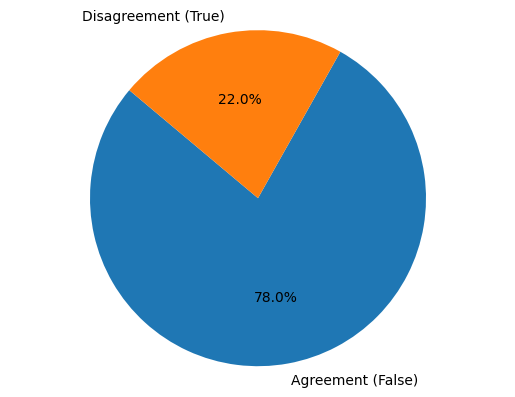

In [ ]:
import matplotlib.pyplot as plt

true_count = len(slur_expert[slur_expert['disagreement'] == True])

total_entries = len(slur_expert)
true_proportion = true_count / total_entries

false_proportion = 1 - true_proportion

labels = ['Agreement (False)', 'Disagreement (True)']
sizes = [false_proportion, true_proportion]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

plt.axis('equal')
plt.show()

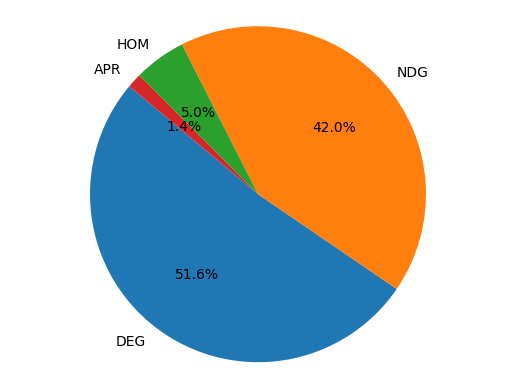

In [ ]:
# Calculate the value counts for the 'gold_label' column
value_counts = slur_expert['gold_label'].value_counts()
labels = value_counts.index.tolist()
sizes = value_counts.values.tolist()

# Create a pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.show()

In [ ]:
## For the purposes of this task, the labels are hate speech (Derogratory) x normal (Non Derogatory Non Appropriative, Homonym, Appropriative)

label_mapping = {'DEG': 0, 'NDG': 1, 'HOM': 1, 'APR': 1}
slur_expert['gold_label'] = slur_expert['gold_label'].replace(label_mapping).astype(int)

<ipython-input-11-8e125e821c9f>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  slur_expert['gold_label'] = slur_expert['gold_label'].replace(label_mapping).astype(int)


In [ ]:
agreed_slur_expert = slur_expert[slur_expert['disagreement'] == False].copy()

In [ ]:
# Function to create synthetic posts
def create_synthetic_posts(df):
    slur_to_post_id = {}
    synthetic_posts = []

    for i, row in df.iterrows():
        slur = row['slur']

        # Check if the synthetic post for this slur already exists
        if slur in slur_to_post_id:
            synthetic_post_id = slur_to_post_id[slur]
        else:
            # Create a new synthetic post ID
            synthetic_post_id = f'synthetic_{slur}'
            slur_to_post_id[slur] = synthetic_post_id

            # Create the synthetic post
            synthetic_post = {
                'id': synthetic_post_id,
                'link_id': row['link_id'],
                'parent_id': '',  # Synthetic post, so no parent
                'score': 0,  # Assuming synthetic posts have a score of 0
                'slur': slur,
                'body': slur,
                'disagreement': False,
                'gold_label': 1
            }
            synthetic_posts.append(synthetic_post)

        # Update the parent_id of the comment to the synthetic post ID
        df.at[i, 'parent_id'] = synthetic_post_id

    # Create a DataFrame for synthetic posts and concatenate with the original DataFrame
    synthetic_df = pd.DataFrame(synthetic_posts)
    return pd.concat([df, synthetic_df], ignore_index=True)

# Create synthetic posts and update the DataFrame
agreed_df = create_synthetic_posts(agreed_slur_expert)
agreed_df.head()

,id,link_id,parent_id,score,slur,body,disagreement,gold_label
0,t1_c3s59yl,t3_pta2s,synthetic_tranny,10.0,tranny,Fuck that I dont wanna watch tranny porn.,False,0
1,t1_e5li3m3,t3_9e0lfg,synthetic_tranny,34.0,tranny,Opie just wanted to have a good time. The same...,False,0
2,t1_e5tpq0a,t3_9f3ytm,synthetic_faggot,61.0,faggot,Fuck that faggot Fallon. Fucking sissy boy act...,False,0
3,t1_c93xbko,t3_1b5k0c,synthetic_faggot,605.0,faggot,BbBB...b.b..b.bb but OP's a faggot,False,0
4,t1_e1wwfj1,t3_8wj0bg,synthetic_tranny,8.0,tranny,Who even uses the word tranny except for trans...,False,1


In [ ]:
agreed_df.parent_id.unique()

array(['synthetic_tranny', 'synthetic_faggot', 'synthetic_nigger', ''],
      dtype=object)

In [ ]:
test_df = agreed_df.sample(n=1000).reset_index()
test_df = create_synthetic_posts(test_df)

test_df = test_df[['body','gold_label']]
test_df.head()

,body,gold_label
0,What stupid education telling us all from Afri...,0
1,OP sure is a faggot,0
2,"He may be a nazi, but at least he ain't a tran...",0
3,Obama confirmed there was a tap put on trump b...,0
4,Islam is not a race lmao. It's a religion crea...,0


In [ ]:
# Get data

slur_df = agreed_slur_expert[['body','gold_label']]

In [ ]:
from sklearn.model_selection import train_test_split

trainDF, testDF = train_test_split(slur_df, test_size=0.2, random_state=42)

# Reset the indices of train_df and test_df
trainDF.reset_index(drop=True, inplace=True)
testDF.reset_index(drop=True, inplace=True)

print("Training dataset shape:", trainDF.shape)
print("Testing dataset shape:", testDF.shape)

print(trainDF.head())

Training dataset shape: (24826, 2)
Testing dataset shape: (6207, 2)
                                                body  gold_label
0  &gt; yeah i think it's just about time to wrap...           1
1  ofc, I think thats kinda the natural way, My d...           0
2  Great, then a new word will come up. It still ...           1
3  By that logic, it's perfectly alright to call ...           1
4  I have no problemm with the transgenderes they...           0


In [ ]:
x_train = trainDF['body'].tolist()
y_train = trainDF['gold_label'].tolist()

x_test = testDF['body'].tolist()
y_test = testDF['gold_label'].tolist()

In [ ]:
trainDF, testDF = train_test_split(test_df, test_size=0.2, random_state=42)

train_x = trainDF['body'].tolist()
train_y = trainDF['gold_label'].tolist()

test_x = testDF['body'].tolist()
test_y = testDF['gold_label'].tolist()

## Sarcasm Dataset

In [ ]:
sarcasm_expert = pd.read_csv("train.En.csv")
sarcasm_expert.head()

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
sarcasm_df = pd.DataFrame(columns=["text", "label"])

for index, row in sarcasm_expert.iterrows():

  sarcasm_df = pd.concat([sarcasm_df, pd.DataFrame({"text": [row["tweet"]], "label": [1]})], ignore_index=True)

  # Add rephrased non-sarcastic tweet (label 0) if it exists
  if pd.notnull(row["rephrase"]):
    sarcasm_df = pd.concat([sarcasm_df, pd.DataFrame({"text": [row["rephrase"]], "label": [0]})], ignore_index=True)

# Add non-sarcastic tweets
non_sarcastic_tweets = sarcasm_expert[sarcasm_expert["sarcastic"] == 0]
non_sarcastic_tweets = non_sarcastic_tweets.rename(columns={"tweet": "text", "sarcastic": "label"})
sarcasm_df = pd.concat([sarcasm_df, non_sarcastic_tweets[["text", "label"]]], ignore_index=True)

sarcasm_df["text"] = sarcasm_df["text"].astype(str)
sarcasm_df["label"] = sarcasm_df["label"].astype(int)

# View the first few rows of sarcasm_df
sarcasm_df.head()

,text,label
0,The only thing I got from college is a caffein...,1
1,"College is really difficult, expensive, tiring...",0
2,I love it when professors draw a big question ...,1
3,I do not like when professors don’t write out ...,0
4,Remember the hundred emails from companies whe...,1


## Validation df

In [ ]:
val_df = pd.read_csv("HS expert.csv", header=None)
val_df[0] = val_df[0].astype(str)

In [ ]:
val_df.rename(columns={0: 'text'}, inplace=True)
val_df.rename(columns={1: 'label'}, inplace=True)

## Preprocessing

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
!pip install wordcloud

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk import pos_tag
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import re

tok = WordPunctTokenizer()

def clean_text(text):
  """
  Cleans text by removing HTML tags, numbers, punctuation (except .,!?(), /), and extra spaces.
  Maintains repetition of parentheses.

  Args:
      text (str): The text to be cleaned.

  Returns:
      str: The cleaned text.
  """
  text = re.sub(r'\>>\d+', '', text)
  # Remove HTML tags
  text = re.sub("\'", "", text)
  # Remove numbers
  text = re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", "", text)
  # Remove smart quotes
  text = re.sub("(?<=\w)[‘`’'](?=\w)", '', text)
  # Replace greater than symbol with space
  text = re.sub(r'&gt;', ' ', text)
  # Remove HTML tags again (in case nested)
  text = re.sub(r'<[^>]*>', ' ', text)
  text = re.sub(r'[^\w\s()]|http\S+', '', text)
  # Lowercase text
  text = text.lower()
  # Remove non-alphanumeric characters except for .,!?(), / and keep repeated parenthesis
  text = re.sub(r'[^\w\s\.,!?\\]+|[\(\)]', "", text)
  # Remove extra spaces
  text = re.sub(r'\s+', ' ', text).strip()
  return text

def preprocess_comments(comments):
  # Make all words lowercase (combine steps 1 & 2)
  comments2 = comments.apply(clean_text)

  # Tokenization
  tokenized_comments = []
  for comment in comments2:
      tokenized_comments.append(tok.tokenize(comment))

  # Remove stopwords using set comprehension
  stop_words = set(stopwords.words("english"))
  tokenized_comments2 = [
      [word for word in comment if word.lower() not in stop_words]
      for comment in tokenized_comments
  ]

  # Count the frequency of each word
  word_counts = Counter([word for comment in tokenized_comments2 for word in comment])

  return comments2, tokenized_comments2, word_counts


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [ ]:
#read extracted data
df_posts = agreed_df
df_posts['body'] = df_posts['body'].apply(clean_text)
df_posts.head()

,id,link_id,parent_id,score,slur,body,disagreement,gold_label
0,t1_c3s59yl,t3_pta2s,synthetic_tranny,10.0,tranny,fuck that i dont wanna watch tranny porn,False,0
1,t1_e5li3m3,t3_9e0lfg,synthetic_tranny,34.0,tranny,opie just wanted to have a good time the same ...,False,0
2,t1_e5tpq0a,t3_9f3ytm,synthetic_faggot,61.0,faggot,fuck that faggot fallon fucking sissy boy acti...,False,0
3,t1_c93xbko,t3_1b5k0c,synthetic_faggot,605.0,faggot,bbbbbbbbb but ops a faggot,False,0
4,t1_e1wwfj1,t3_8wj0bg,synthetic_tranny,8.0,tranny,who even uses the word tranny except for trans...,False,1


In [ ]:
len(df_posts)

31036

In [ ]:
# Tokenize the comments
train_comments = df_posts.body.astype(str)
train_comments, train_tc, train_wc = preprocess_comments(train_comments)


In [ ]:
# read extracted data
df_posts2 = chan.copy()
# Remove citations from comments
df_posts2['text'] = df_posts2['text'].apply(clean_text)

train_comments2 = df_posts2.text.astype(str)
train_comments2, train_tc2, train_wc2 = preprocess_comments(df_posts2.text.astype(str))



In [ ]:
# read extracted data
df_posts3 = sarcasm_df.copy()
# Remove citations from comments
df_posts3['text'] = df_posts3['text'].apply(clean_text)

train_comments3 = df_posts3.text.astype(str)
train_comments3, train_tc3, train_wc3 = preprocess_comments(df_posts3.text.astype(str))


In [ ]:
val_df['text'] = val_df['text'].apply(clean_text)

val_com = val_df.text.astype(str)
val_com, val_tc, val_wc = preprocess_comments(val_df.text.astype(str))

## Data preparing

In [ ]:
slur_test = df_posts[21000:22000]
df_posts = df_posts[0:10000]
df_posts3 = df_posts3[0:10000]

In [ ]:
import torch
from transformers import BertTokenizer, BertModel, GraphormerConfig, GraphormerForGraphClassification
from nltk.tokenize import sent_tokenize
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split, RandomSampler, SequentialSampler
import torch
from tqdm import tqdm
import gc
import os

# Load tokenizer and model on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def tokenize_sentences(sentences):
    input_ids = []
    attention_masks = []

    for sentence in sentences:
        encoded_dict = tokenizer.encode_plus(
            sentence,                      # Sentence to encode
            add_special_tokens=True,       # Add '[CLS]' and '[SEP]'
            max_length=128,                # Pad & truncate all sentences
            padding='max_length',
            return_attention_mask=True,    # Construct attention masks
            return_tensors='pt',           # Return pytorch tensors
            truncation=True
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

input_ids, attention_masks = tokenize_sentences(df_posts['body'])
labels = torch.tensor(df_posts['gold_label'].values).to(device)

In [ ]:
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_token_embeddings(model, input_ids, attention_masks, batch_size=32):
    model.eval()
    all_embeddings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(input_ids), batch_size), desc="Getting token embeddings"):
            batch_input_ids = input_ids[i:i+batch_size].to(device)  # Move tensors to the device
            batch_attention_masks = attention_masks[i:i+batch_size].to(device)

            outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
            embeddings = outputs.last_hidden_state.cpu()  # Move embeddings back to CPU

            all_embeddings.append(embeddings)

            del batch_input_ids, batch_attention_masks, outputs
            torch.cuda.empty_cache()
            gc.collect()

    return torch.cat(all_embeddings, dim=0)

embeddings = get_token_embeddings(bert_model, input_ids, attention_masks)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Getting token embeddings: 100%|██████████| 313/313 [02:27<00:00,  2.12it/s]


In [ ]:
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
slur_input_ids, slur_attention_masks = tokenize_sentences(slur_test['body'])
slur_labels = torch.tensor(slur_test['gold_label'].values).to(device)
slur_input_ids = slur_input_ids.to(device)
slur_attention_masks = slur_attention_masks.to(device)

slur_embeddings = get_token_embeddings(bert_model, slur_input_ids, slur_attention_masks)

Getting token embeddings: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]


In [ ]:
chan_input_ids, chan_attention_masks = tokenize_sentences(df_posts2['text'])
chan_labels = torch.tensor(df_posts2['label'].values).to(device)
chan_input_ids = chan_input_ids.to(device)
chan_attention_masks = chan_attention_masks.to(device)

chan_embeddings = get_token_embeddings(bert_model, chan_input_ids, chan_attention_masks)

Getting token embeddings: 100%|██████████| 26/26 [00:11<00:00,  2.18it/s]


In [ ]:
#for sarcasm

sarc_input_ids, sarc_attention_masks = tokenize_sentences(df_posts3['text'])
sarc_labels = torch.tensor(df_posts3['label'].values).to(device)
sarc_input_ids = sarc_input_ids.to(device)
sarc_attention_masks = sarc_attention_masks.to(device)

text_column = 'text'
label_column = 'label'
sarc_embeddings = get_token_embeddings(bert_model, sarc_input_ids, sarc_attention_masks)

Getting token embeddings: 100%|██████████| 217/217 [01:42<00:00,  2.12it/s]


In [ ]:
val_input_ids, val_attention_masks = tokenize_sentences(val_df["text"])
val_labels = torch.tensor(val_df["label"].values).to(device)
val_input_ids = val_input_ids.to(device)
val_attention_masks = val_attention_masks.to(device)

val_embeddings = get_token_embeddings(bert_model, val_input_ids, val_attention_masks)

Getting token embeddings: 100%|██████████| 6/6 [00:02<00:00,  2.20it/s]


# Experimentos

## TF-IDF
SVM, Random Forest and LSTM


In [ ]:
#TF-IDF Features-F1
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(df_posts['body'])
tfidf_matrix = tfidf
tfidf.shape

(10000, 10000)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Split the data into train and test sets
X = tfidf
y = df_posts['gold_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LinearSVC": LinearSVC(random_state=20),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": MultinomialNB()
}

# Function to save false predictions
def save_false_predictions(model, X_test, y_test):
    y_preds = model.predict(X_test)
    false_predictions = X_test[y_preds != y_test]  # Selecting instances where predictions don't match true labels
    return false_predictions

Random Forest, Accuracy Score: 0.8125
Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1313
           1       0.82      0.59      0.68       687

    accuracy                           0.81      2000
   macro avg       0.81      0.76      0.77      2000
weighted avg       0.81      0.81      0.80      2000



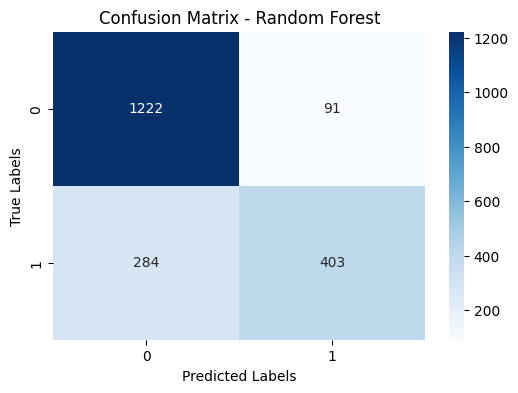

LinearSVC, Accuracy Score: 0.8525
Classification Report (LinearSVC):
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1313
           1       0.81      0.75      0.78       687

    accuracy                           0.85      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.85      0.85      0.85      2000



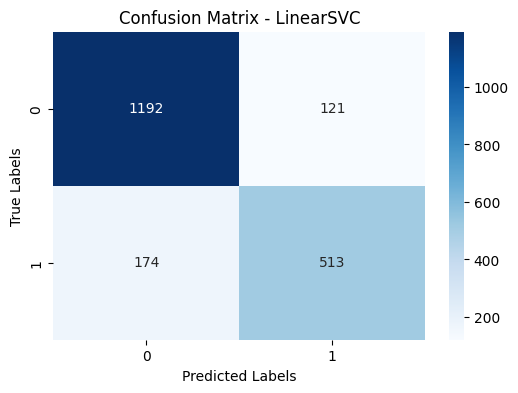

KNN, Accuracy Score: 0.789
Classification Report (KNN):
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      1313
           1       0.81      0.51      0.62       687

    accuracy                           0.79      2000
   macro avg       0.80      0.72      0.74      2000
weighted avg       0.79      0.79      0.77      2000



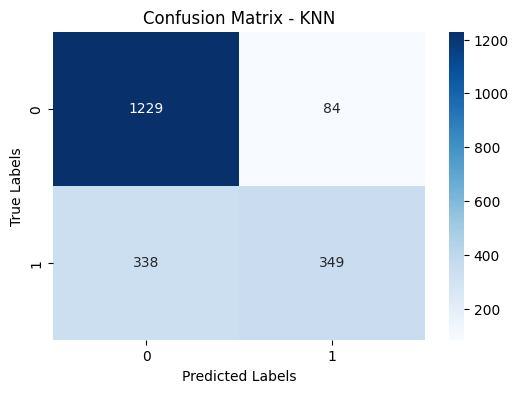

Naive Bayes, Accuracy Score: 0.845
Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1313
           1       0.89      0.62      0.73       687

    accuracy                           0.84      2000
   macro avg       0.86      0.79      0.81      2000
weighted avg       0.85      0.84      0.84      2000



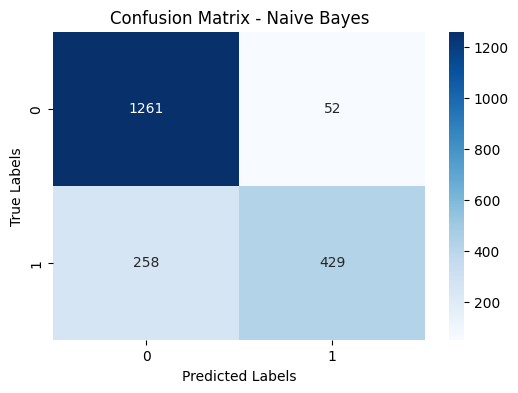

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
# Initialize dictionary to store wrong predictions
wrong_predictions = {clf_name: [] for clf_name in classifiers}

# Train and evaluate classifiers
for clf_name, clf in classifiers.items():
    # Train
    clf.fit(X_train, y_train)

    # Make predictions
    y_preds = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_preds)
    print(f"{clf_name}, Accuracy Score: {accuracy}")

    # Generate classification report
    report = classification_report(y_test, y_preds)
    print(f"Classification Report ({clf_name}):\n{report}")

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_preds)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {clf_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Store wrong predictions
    wrong_indices = X_test[y_preds != y_test].toarray()
    wrong_text = ["".join(map(str, row)) for row in wrong_indices]
    wrong_predictions[clf_name].extend(wrong_text)

# Count the number of wrong predictions for each classifier
wrong_counts = {clf_name: predictions.shape[0] for clf_name, predictions in wrong_predictions.items()}
sorted_wrong_counts = sorted(wrong_counts.items(), key=lambda x: x[1], reverse=True)

all_wrong_text = [text for _, text_list in wrong_predictions.items() for text in text_list]
wrong_text_counts = Counter(all_wrong_text)
sorted_wrong_text_counts = wrong_text_counts.most_common()
for text, count in sorted_wrong_text_counts:
    print(f"Text: {text}, Count: {count}")

Random Forest, Accuracy Score: 0.8255
Classification Report without tokenization (Random Forest):
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1313
           1       0.83      0.62      0.71       687

    accuracy                           0.83      2000
   macro avg       0.83      0.78      0.79      2000
weighted avg       0.83      0.83      0.82      2000



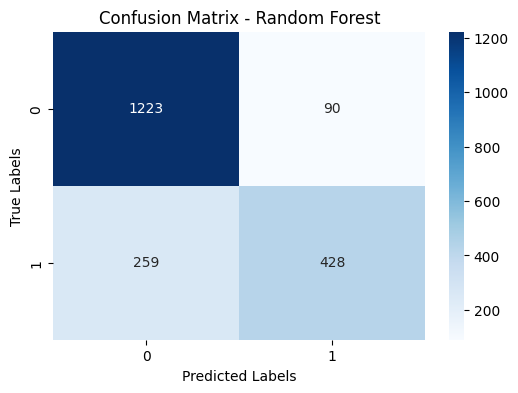

LinearSVC, Accuracy Score: 0.8525
Classification Report without tokenization (LinearSVC):
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1313
           1       0.81      0.75      0.78       687

    accuracy                           0.85      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.85      0.85      0.85      2000



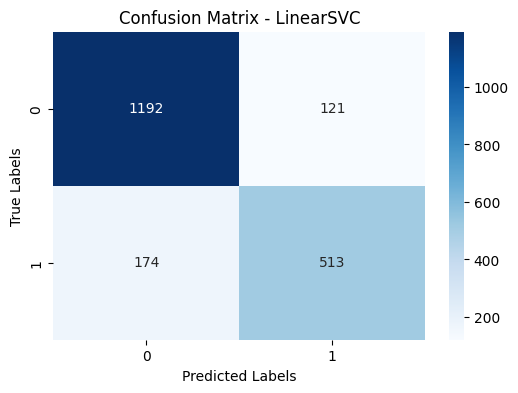

KNN, Accuracy Score: 0.789
Classification Report without tokenization (KNN):
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      1313
           1       0.81      0.51      0.62       687

    accuracy                           0.79      2000
   macro avg       0.80      0.72      0.74      2000
weighted avg       0.79      0.79      0.77      2000



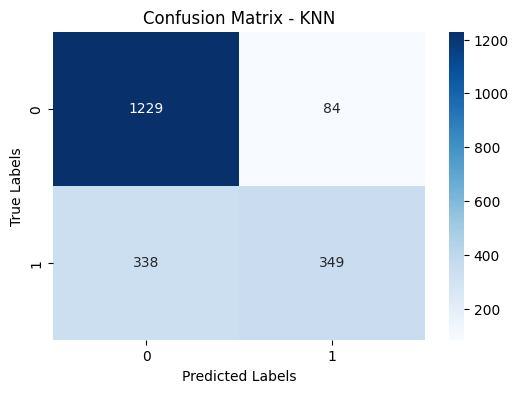

Naive Bayes, Accuracy Score: 0.845
Classification Report without tokenization (Naive Bayes):
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1313
           1       0.89      0.62      0.73       687

    accuracy                           0.84      2000
   macro avg       0.86      0.79      0.81      2000
weighted avg       0.85      0.84      0.84      2000



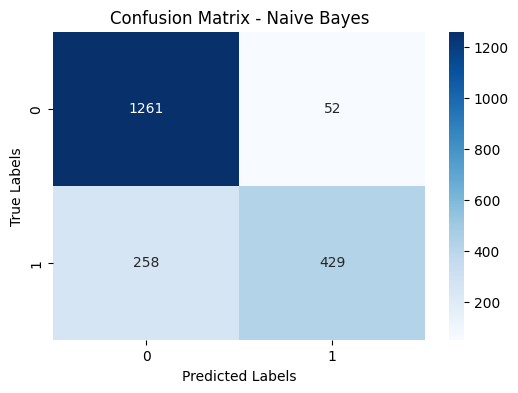

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
# Initialize dictionary to store wrong predictions
wrong_predictions = {clf_name: [] for clf_name in classifiers}

# Train and evaluate classifiers
for clf_name, clf in classifiers.items():
    # Train
    clf.fit(X_train, y_train)

    # Make predictions
    y_preds = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_preds)
    print(f"{clf_name}, Accuracy Score: {accuracy}")

    # Generate classification report
    report = classification_report(y_test, y_preds)
    print(f"Classification Report without tokenization ({clf_name}):\n{report}")

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_preds)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {clf_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Store wrong predictions
    wrong_indices = X_test[y_preds != y_test].toarray()
    wrong_text = ["".join(map(str, row)) for row in wrong_indices]
    wrong_predictions[clf_name].extend(wrong_text)

# Count the number of wrong predictions for each classifier
wrong_counts = {clf_name: predictions.shape[0] for clf_name, predictions in wrong_predictions.items()}
sorted_wrong_counts = sorted(wrong_counts.items(), key=lambda x: x[1], reverse=True)

all_wrong_text = [text for _, text_list in wrong_predictions.items() for text in text_list]
wrong_text_counts = Counter(all_wrong_text)
sorted_wrong_text_counts = wrong_text_counts.most_common()
for text, count in sorted_wrong_text_counts:
    print(f"Text: {text}, Count: {count}")

Iteration 1:

Random Forest, Accuracy Score: 0.812
LinearSVC, Accuracy Score: 0.8525
KNN, Accuracy Score: 0.789
Naive Bayes, Accuracy Score: 0.845
Iteration 2:

Random Forest, Accuracy Score: 0.819
LinearSVC, Accuracy Score: 0.8525
KNN, Accuracy Score: 0.789
Naive Bayes, Accuracy Score: 0.845
Iteration 3:

Random Forest, Accuracy Score: 0.822
LinearSVC, Accuracy Score: 0.8525
KNN, Accuracy Score: 0.789
Naive Bayes, Accuracy Score: 0.845
Iteration 4:

Random Forest, Accuracy Score: 0.819
LinearSVC, Accuracy Score: 0.8525
KNN, Accuracy Score: 0.789
Naive Bayes, Accuracy Score: 0.845
Iteration 5:

Random Forest, Accuracy Score: 0.819
LinearSVC, Accuracy Score: 0.8525
KNN, Accuracy Score: 0.789
Naive Bayes, Accuracy Score: 0.845
Iteration 6:

Random Forest, Accuracy Score: 0.8235
LinearSVC, Accuracy Score: 0.8525
KNN, Accuracy Score: 0.789
Naive Bayes, Accuracy Score: 0.845
Iteration 7:

Random Forest, Accuracy Score: 0.8155
LinearSVC, Accuracy Score: 0.8525
KNN, Accuracy Score: 0.789
Naiv

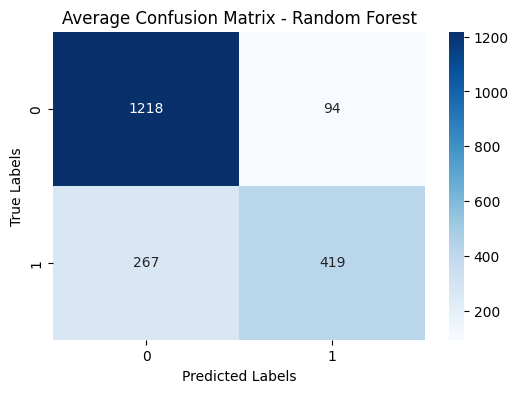


Average Classification Report (LinearSVC):
{'0': {'precision': 0.8726207906295753, 'recall': 0.9078446306169077, 'f1-score': 0.8898842851810377, 'support': 1313.0}, '1': {'precision': 0.8091482649842272, 'recall': 0.7467248908296942, 'f1-score': 0.7766843300529903, 'support': 687.0}, 'accuracy': 0.8525, 'macro avg': {'precision': 0.8408845278069013, 'recall': 0.8272847607233011, 'f1-score': 0.8332843076170138, 'support': 2000.0}, 'weighted avg': {'precision': 0.8508179780703984, 'recall': 0.8525, 'f1-score': 0.8510001005945533, 'support': 2000.0}}


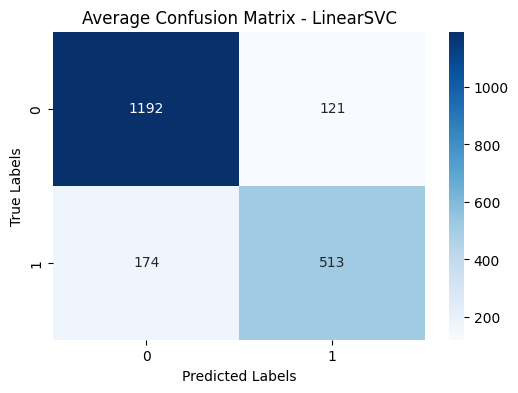


Average Classification Report (KNN):
{'0': {'precision': 0.7843012125079769, 'recall': 0.936024371667936, 'f1-score': 0.8534722222222222, 'support': 1313.0}, '1': {'precision': 0.8060046189376442, 'recall': 0.5080058224163028, 'f1-score': 0.6232142857142858, 'support': 687.0}, 'accuracy': 0.7889999999999999, 'macro avg': {'precision': 0.7951529157228105, 'recall': 0.7220150970421193, 'f1-score': 0.738343253968254, 'support': 2000.0}, 'weighted avg': {'precision': 0.7917563326165676, 'recall': 0.7889999999999999, 'f1-score': 0.7743786210317458, 'support': 2000.0}}


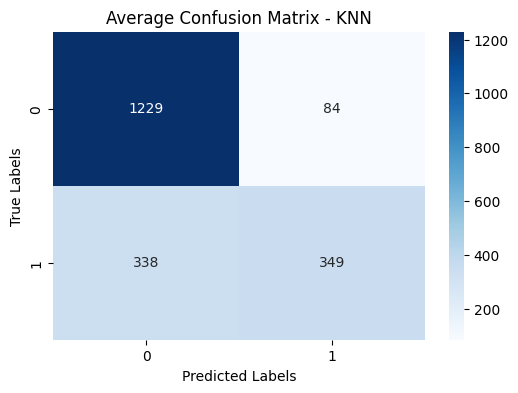


Average Classification Report (Naive Bayes):
{'0': {'precision': 0.8301514154048715, 'recall': 0.9603960396039604, 'f1-score': 0.8905367231638419, 'support': 1313.0}, '1': {'precision': 0.8918918918918919, 'recall': 0.6244541484716156, 'f1-score': 0.7345890410958905, 'support': 687.0}, 'accuracy': 0.845, 'macro avg': {'precision': 0.8610216536483817, 'recall': 0.792425094037788, 'f1-score': 0.812562882129866, 'support': 2000.0}, 'weighted avg': {'precision': 0.8513592690781631, 'recall': 0.845, 'f1-score': 0.8369686943735004, 'support': 2000.0}}


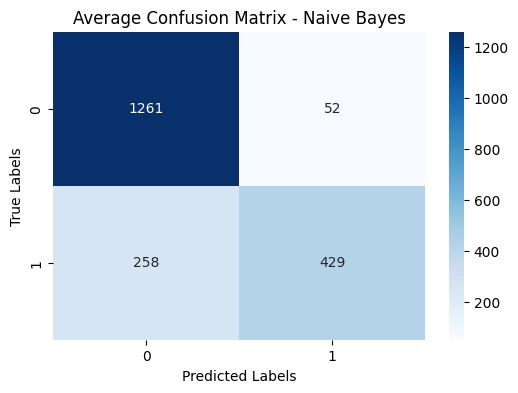

In [ ]:
# Define the number of iterations
num_iterations = 10

# Initialize dictionary to store wrong predictions
wrong_predictions = {clf_name: [] for clf_name in classifiers}

# Initialize lists to store classification reports and confusion matrices
classification_reports = {clf_name: [] for clf_name in classifiers}
confusion_matrices = {clf_name: [] for clf_name in classifiers}

# Train and evaluate classifiers for each iteration
for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}:\n")
    for clf_name, clf in classifiers.items():
        # Train
        clf.fit(X_train, y_train)

        # Make predictions
        y_preds = clf.predict(X_test)

        # Store wrong predictions
        wrong_predictions[clf_name].extend(X_test[y_preds != y_test])

        # Generate classification report
        report = classification_report(y_test, y_preds, output_dict=True)
        classification_reports[clf_name].append(report)

        # Generate confusion matrix
        cm = confusion_matrix(y_test, y_preds)
        confusion_matrices[clf_name].append(cm)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_preds)
        print(f"{clf_name}, Accuracy Score: {accuracy}")

# Average the classification reports
avg_classification_reports = {}
for clf_name, reports in classification_reports.items():
    avg_classification_reports[clf_name] = {}
    for label in reports[0].keys():
        if isinstance(reports[0][label], dict):
            avg_classification_reports[clf_name][label] = {}
            for metric in reports[0][label].keys():
                avg_classification_reports[clf_name][label][metric] = sum(report[label][metric] for report in reports) / num_iterations
        else:
            # Handle the case where the value is a float (e.g., 'accuracy', 'macro avg', 'weighted avg')
            avg_classification_reports[clf_name][label] = sum(report[label] for report in reports) / num_iterations

# Average the confusion matrices
avg_confusion_matrices = {clf_name: sum(confusion_matrices[clf_name]) // num_iterations for clf_name in confusion_matrices.keys()}

# Display average classification reports and heatmaps
for clf_name, report in avg_classification_reports.items():
    print(f"\nAverage Classification Report ({clf_name}):\n{report}")
    plt.figure(figsize=(6, 4))
    sns.heatmap(avg_confusion_matrices[clf_name], annot=True, fmt="d", cmap="Blues")
    plt.title(f"Average Confusion Matrix - {clf_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

Iteration 1:

Random Forest, Accuracy Score: 0.5706214689265536
LinearSVC, Accuracy Score: 0.5819209039548022
KNN, Accuracy Score: 0.4124293785310734
Naive Bayes, Accuracy Score: 0.5875706214689266
Iteration 2:

Random Forest, Accuracy Score: 0.5706214689265536
LinearSVC, Accuracy Score: 0.5819209039548022
KNN, Accuracy Score: 0.4124293785310734
Naive Bayes, Accuracy Score: 0.5875706214689266
Iteration 3:

Random Forest, Accuracy Score: 0.5706214689265536
LinearSVC, Accuracy Score: 0.5819209039548022
KNN, Accuracy Score: 0.4124293785310734
Naive Bayes, Accuracy Score: 0.5875706214689266
Iteration 4:

Random Forest, Accuracy Score: 0.5706214689265536
LinearSVC, Accuracy Score: 0.5819209039548022
KNN, Accuracy Score: 0.4124293785310734
Naive Bayes, Accuracy Score: 0.5875706214689266
Iteration 5:

Random Forest, Accuracy Score: 0.5706214689265536
LinearSVC, Accuracy Score: 0.5819209039548022
KNN, Accuracy Score: 0.4124293785310734
Naive Bayes, Accuracy Score: 0.5875706214689266
Iteration 

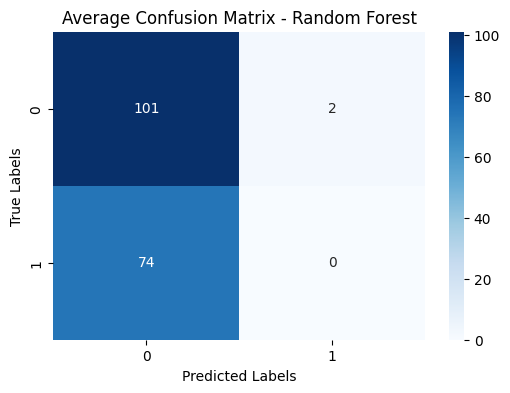


 Validation Average Classification Report (LinearSVC):
{'0': {'precision': 0.5868263473053892, 'recall': 0.9514563106796119, 'f1-score': 0.7259259259259261, 'support': 103.0}, '1': {'precision': 0.5, 'recall': 0.06756756756756756, 'f1-score': 0.11904761904761904, 'support': 74.0}, 'accuracy': 0.5819209039548021, 'macro avg': {'precision': 0.5434131736526947, 'recall': 0.5095119391235895, 'f1-score': 0.4224867724867726, 'support': 177.0}, 'weighted avg': {'precision': 0.5505260665110459, 'recall': 0.5819209039548021, 'f1-score': 0.47220279197680337, 'support': 177.0}}


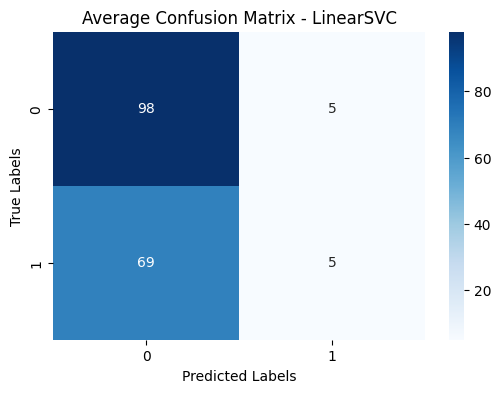


 Validation Average Classification Report (KNN):
{'0': {'precision': 0.49315068493150693, 'recall': 0.3495145631067961, 'f1-score': 0.40909090909090906, 'support': 103.0}, '1': {'precision': 0.3557692307692308, 'recall': 0.5, 'f1-score': 0.4157303370786517, 'support': 74.0}, 'accuracy': 0.4124293785310734, 'macro avg': {'precision': 0.42445995785036883, 'recall': 0.4247572815533981, 'f1-score': 0.4124106230847805, 'support': 177.0}, 'weighted avg': {'precision': 0.4357143707619676, 'recall': 0.4124293785310734, 'f1-score': 0.4118667151422818, 'support': 177.0}}


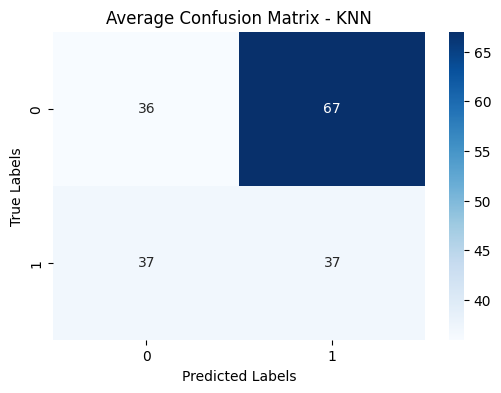


 Validation Average Classification Report (Naive Bayes):
{'0': {'precision': 0.5872093023255813, 'recall': 0.9805825242718449, 'f1-score': 0.7345454545454545, 'support': 103.0}, '1': {'precision': 0.5999999999999999, 'recall': 0.04054054054054055, 'f1-score': 0.07594936708860758, 'support': 74.0}, 'accuracy': 0.5875706214689266, 'macro avg': {'precision': 0.5936046511627906, 'recall': 0.5105615324061927, 'f1-score': 0.4052474108170311, 'support': 177.0}, 'weighted avg': {'precision': 0.5925568256470897, 'recall': 0.5875706214689266, 'f1-score': 0.459200197642592, 'support': 177.0}}


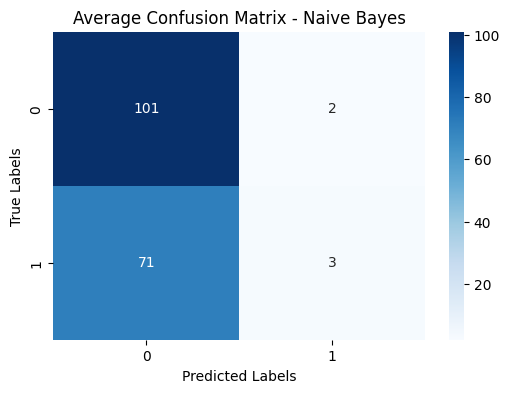

Prediction details for Random Forest saved to Random Forest_predictions.csv
Prediction details for LinearSVC saved to LinearSVC_predictions.csv
Prediction details for KNN saved to KNN_predictions.csv
Prediction details for Naive Bayes saved to Naive Bayes_predictions.csv


In [ ]:
X_val = val_df['text']
y_val = val_df['label']

X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Define the number of iterations
num_iterations = 10

# Initialize dictionaries to store results
wrong_predictions = {clf_name: [] for clf_name in classifiers}
classification_reports = {clf_name: [] for clf_name in classifiers}
confusion_matrices = {clf_name: [] for clf_name in classifiers}
prediction_details = {clf_name: [] for clf_name in classifiers}

# Evaluate classifiers for each iteration
for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}:\n")
    for clf_name, clf in classifiers.items():
        # Make predictions
        y_preds = clf.predict(X_val_tfidf)

        # Store prediction details
        for text, true_label, pred_label in zip(X_val, y_val, y_preds):
            prediction_details[clf_name].append({'text': text, 'true_label': true_label, 'pred_label': pred_label})

        # Store wrong predictions
        wrong_predictions[clf_name].extend(X_val[y_preds != y_val])

        # Generate classification report
        report = classification_report(y_val, y_preds, output_dict=True)
        classification_reports[clf_name].append(report)

        # Generate confusion matrix
        cm = confusion_matrix(y_val, y_preds)
        confusion_matrices[clf_name].append(cm)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_preds)
        print(f"{clf_name}, Accuracy Score: {accuracy}")

# Average the classification reports
avg_classification_reports = {}
for clf_name, reports in classification_reports.items():
    avg_classification_reports[clf_name] = {}
    for label in reports[0].keys():
        if isinstance(reports[0][label], dict):
            avg_classification_reports[clf_name][label] = {}
            for metric in reports[0][label].keys():
                avg_classification_reports[clf_name][label][metric] = sum(report[label][metric] for report in reports) / num_iterations
        else:
            avg_classification_reports[clf_name][label] = sum(report[label] for report in reports) / num_iterations

# Average the confusion matrices
avg_confusion_matrices = {clf_name: sum(confusion_matrices[clf_name]) // num_iterations for clf_name in confusion_matrices.keys()}

# Display average classification reports and heatmaps
for clf_name, report in avg_classification_reports.items():
    print(f"\n Validation Average Classification Report ({clf_name}):\n{report}")
    plt.figure(figsize=(6, 4))
    sns.heatmap(avg_confusion_matrices[clf_name], annot=True, fmt="d", cmap="Blues")
    plt.title(f"Average Confusion Matrix - {clf_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Create a DataFrame for the prediction details of each classifier
for clf_name, details in prediction_details.items():
    prediction_df = pd.DataFrame(details)
    prediction_df.to_csv(f"{clf_name}_predictions.csv", index=False)
    print(f"Prediction details for {clf_name} saved to {clf_name}_predictions.csv")


Iteration 1:

Random Forest, Accuracy Score: 0.22126081582200247
LinearSVC, Accuracy Score: 0.3189122373300371
KNN, Accuracy Score: 0.2657601977750309
Naive Bayes, Accuracy Score: 0.24721878862793573
Iteration 2:

Random Forest, Accuracy Score: 0.22126081582200247
LinearSVC, Accuracy Score: 0.3189122373300371
KNN, Accuracy Score: 0.2657601977750309
Naive Bayes, Accuracy Score: 0.24721878862793573
Iteration 3:

Random Forest, Accuracy Score: 0.22126081582200247
LinearSVC, Accuracy Score: 0.3189122373300371
KNN, Accuracy Score: 0.2657601977750309
Naive Bayes, Accuracy Score: 0.24721878862793573
Iteration 4:

Random Forest, Accuracy Score: 0.22126081582200247
LinearSVC, Accuracy Score: 0.3189122373300371
KNN, Accuracy Score: 0.2657601977750309
Naive Bayes, Accuracy Score: 0.24721878862793573
Iteration 5:

Random Forest, Accuracy Score: 0.22126081582200247
LinearSVC, Accuracy Score: 0.3189122373300371
KNN, Accuracy Score: 0.2657601977750309
Naive Bayes, Accuracy Score: 0.24721878862793573


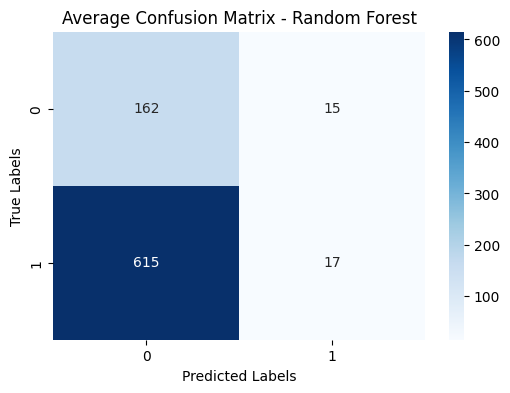


 4chan Average Classification Report (LinearSVC):
{'0': {'precision': 0.21921921921921922, 'recall': 0.8248587570621468, 'f1-score': 0.3463819691577699, 'support': 177.0}, '1': {'precision': 0.7832167832167832, 'recall': 0.17721518987341775, 'f1-score': 0.28903225806451616, 'support': 632.0}, 'accuracy': 0.3189122373300371, 'macro avg': {'precision': 0.5012180012180013, 'recall': 0.5010369734677822, 'f1-score': 0.31770711361114307, 'support': 809.0}, 'weighted avg': {'precision': 0.6598205300306661, 'recall': 0.3189122373300371, 'f1-score': 0.30157972266711924, 'support': 809.0}}


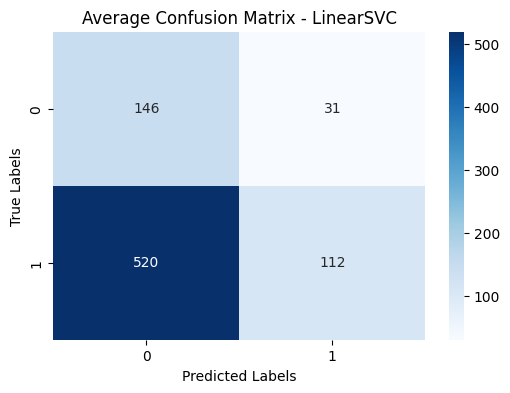


 4chan Average Classification Report (KNN):
{'0': {'precision': 0.2147742818057456, 'recall': 0.887005649717514, 'f1-score': 0.34581497797356825, 'support': 177.0}, '1': {'precision': 0.7435897435897436, 'recall': 0.0917721518987342, 'f1-score': 0.16338028169014085, 'support': 632.0}, 'accuracy': 0.26576019777503085, 'macro avg': {'precision': 0.4791820126977446, 'recall': 0.48938890080812414, 'f1-score': 0.2545976298318546, 'support': 809.0}, 'weighted avg': {'precision': 0.627890934274827, 'recall': 0.26576019777503085, 'f1-score': 0.2032949185778623, 'support': 809.0}}


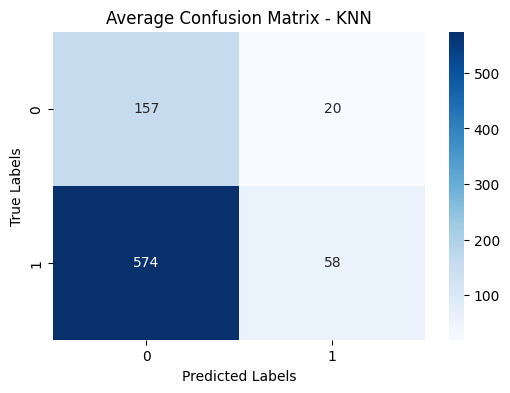


 4chan Average Classification Report (Naive Bayes):
{'0': {'precision': 0.21875, 'recall': 0.9491525423728813, 'f1-score': 0.35555555555555557, 'support': 177.0}, '1': {'precision': 0.7804878048780487, 'recall': 0.05063291139240507, 'f1-score': 0.0950965824665676, 'support': 632.0}, 'accuracy': 0.24721878862793573, 'macro avg': {'precision': 0.4996189024390244, 'recall': 0.49989272688264325, 'f1-score': 0.2253260690110616, 'support': 809.0}, 'weighted avg': {'precision': 0.6575859612891556, 'recall': 0.24721878862793573, 'f1-score': 0.15208204382225474, 'support': 809.0}}


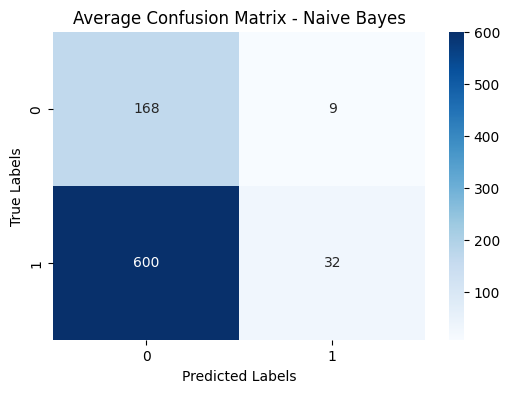

In [ ]:
X_val = chan['text']
y_val = chan['label']

X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Define the number of iterations
num_iterations = 10

# Initialize dictionaries to store results
wrong_predictions = {clf_name: [] for clf_name in classifiers}
classification_reports = {clf_name: [] for clf_name in classifiers}
confusion_matrices = {clf_name: [] for clf_name in classifiers}
prediction_details = {clf_name: [] for clf_name in classifiers}

# Evaluate classifiers for each iteration
for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}:\n")
    for clf_name, clf in classifiers.items():
        # Make predictions
        y_preds = clf.predict(X_val_tfidf)

        # Store prediction details
        for text, true_label, pred_label in zip(X_val, y_val, y_preds):
            prediction_details[clf_name].append({'text': text, 'true_label': true_label, 'pred_label': pred_label})

        # Store wrong predictions
        wrong_predictions[clf_name].extend(X_val[y_preds != y_val])

        # Generate classification report
        report = classification_report(y_val, y_preds, output_dict=True)
        classification_reports[clf_name].append(report)

        # Generate confusion matrix
        cm = confusion_matrix(y_val, y_preds)
        confusion_matrices[clf_name].append(cm)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_preds)
        print(f"{clf_name}, Accuracy Score: {accuracy}")

# Average the classification reports
avg_classification_reports = {}
for clf_name, reports in classification_reports.items():
    avg_classification_reports[clf_name] = {}
    for label in reports[0].keys():
        if isinstance(reports[0][label], dict):
            avg_classification_reports[clf_name][label] = {}
            for metric in reports[0][label].keys():
                avg_classification_reports[clf_name][label][metric] = sum(report[label][metric] for report in reports) / num_iterations
        else:
            avg_classification_reports[clf_name][label] = sum(report[label] for report in reports) / num_iterations

# Average the confusion matrices
avg_confusion_matrices = {clf_name: sum(confusion_matrices[clf_name]) // num_iterations for clf_name in confusion_matrices.keys()}

# Display average classification reports and heatmaps
for clf_name, report in avg_classification_reports.items():
    print(f"\n 4chan Average Classification Report ({clf_name}):\n{report}")
    plt.figure(figsize=(6, 4))
    sns.heatmap(avg_confusion_matrices[clf_name], annot=True, fmt="d", cmap="Blues")
    plt.title(f"Average Confusion Matrix - {clf_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


## Word2Vec
SVM, Random Forest and LSTM




In [ ]:
# Convert each Series to a list and then combine
train_comments_combined = train_comments.tolist() + train_comments2.tolist()

In [ ]:
train_comments

,body
0,fuck that i dont wanna watch tranny porn
1,opie just wanted to have a good time the same ...
2,fuck that faggot fallon fucking sissy boy acti...
3,bbbbbbbbb but ops a faggot
4,who even uses the word tranny except for trans...
...,...
31031,that was hilariously bad they used the insult ...
31032,reddit in regards to a black woman taking cand...
31033,tranny
31034,faggot


In [ ]:
torch.cuda.empty_cache()
gc.collect()

0

Vocabulary size: 13148


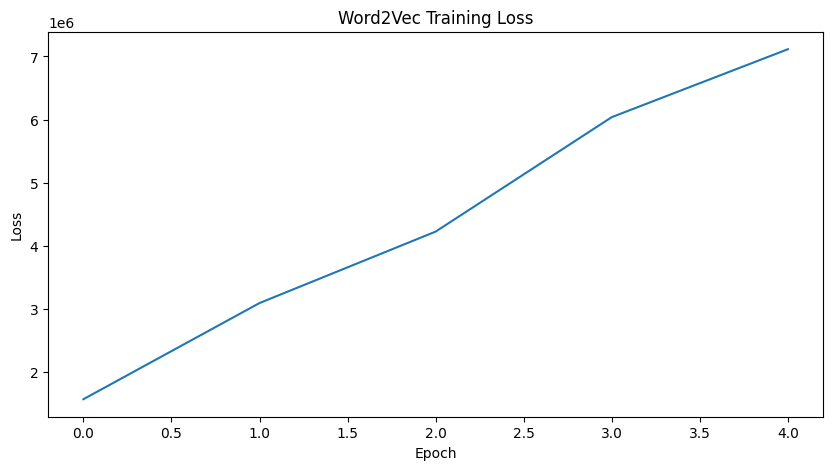


Similar words to 'a':
bionic: 0.6835
another: 0.6709
shitlib: 0.6636
rtraa: 0.6522
femme: 0.6494


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models.callbacks import CallbackAny2Vec

class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        self.losses = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        self.losses.append(loss)
        self.epoch += 1

def train_word2vec(train_comments_combined, evaluate=True):
    # Tokenize the comments into sentences
    train_sentences = []
    for comment in train_comments_combined:
        comment_sentences = sent_tokenize(comment)
        train_sentences.extend(comment_sentences)

    # Tokenize the sentences into words
    train_tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in train_sentences]

    # Initialize epoch logger
    epoch_logger = EpochLogger()

    # Train Word2Vec model with optimized parameters
    model_w2v = gensim.models.Word2Vec(
        sentences=train_tokenized_sentences,
        vector_size=100,           # Reduced from 300 to balance detail and efficiency
        window=5,                  # Increased from 3 to capture broader context
        min_count=3,              # Reduced from 5 to retain more vocabulary
        sg=1,                     # Changed to skip-gram for better handling of rare words
        hs=1,                     # Enabled hierarchical softmax for efficiency
        negative=5,               # Reduced from 20 to optimal value for most cases
        workers=32,               # Kept for parallel processing
        seed=42,                  # Kept for reproducibility
        alpha=0.025,              # Increased learning rate for better initial learning
        min_alpha=0.0001,         # Lower final learning rate for fine convergence
        epochs=5,                 # Explicit number of training epochs
        compute_loss=True,        # Track training loss
        callbacks=[epoch_logger]
    )

    if evaluate:
        # Basic model evaluation
        vocab_size = len(model_w2v.wv.key_to_index)
        print(f"Vocabulary size: {vocab_size}")

        # Plot training loss
        plt.figure(figsize=(10, 5))
        plt.plot(epoch_logger.losses)
        plt.title('Word2Vec Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

        # Demonstrate similar words for a sample
        try:
            sample_word = list(model_w2v.wv.key_to_index.keys())[0]
            similar_words = model_w2v.wv.most_similar(sample_word, topn=5)
            print(f"\nSimilar words to '{sample_word}':")
            for word, score in similar_words:
                print(f"{word}: {score:.4f}")
        except:
            print("Could not demonstrate similar words")

    return model_w2v

model_w2v = train_word2vec(train_comments_combined)

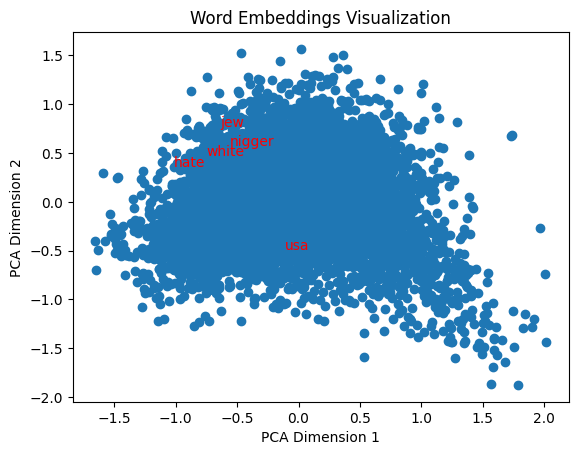

In [ ]:
word_embeddings = model_w2v.wv

word_tokens = word_embeddings.index_to_key

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
word_embeddings_pca = pca.fit_transform(word_embeddings.vectors)

# Plot the word embeddings
plt.scatter(word_embeddings_pca[:, 0], word_embeddings_pca[:, 1])

# Annotate and highlight specific words
highlight_words = ["jew", "usa", "hate", "nigger", "white"]
for i, word in enumerate(word_tokens):
    if word in highlight_words:
        plt.annotate(word, (word_embeddings_pca[i, 0], word_embeddings_pca[i, 1]), color='red')
    else:
        plt.annotate("", (word_embeddings_pca[i, 0], word_embeddings_pca[i, 1]))

plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.title("Word Embeddings Visualization")
plt.show()

In [ ]:
model_w2v.wv.most_similar("fag")

[('retard', 0.7035674452781677),
 ('dyke', 0.6764379143714905),
 ('fagget', 0.6687694191932678),
 ('cigarettes', 0.6669278740882874),
 ('faggot', 0.6634292006492615),
 ('cigarette', 0.6574204564094543),
 ('cocksucker', 0.6568904519081116),
 ('queer', 0.6551240086555481),
 ('homo', 0.6478457450866699),
 ('kike', 0.6387272477149963)]

In [ ]:
model_w2v.wv.most_similar(positive="nigger")

[('cracker', 0.7477912902832031),
 ('essay', 0.7366369366645813),
 ('nigga', 0.7247508764266968),
 ('wetback', 0.7189805507659912),
 ('spic', 0.7108573913574219),
 ('honky', 0.7014864087104797),
 ('paki', 0.7009311318397522),
 ('gook', 0.6994414925575256),
 ('chink', 0.6978389620780945),
 ('forbidden', 0.6953401565551758)]

In [ ]:
import numpy as np
import pandas as pd

def text_to_w2v(df, w2v_model, text_column='text', label_column='label'):
    # Function to get the average vector for each text
    def get_average_vector(text):
        words = text.split()
        word_vectors = [w2v_model[word] for word in words if word in w2v_model]
        if word_vectors:
            return np.mean(word_vectors, axis=0)
        else:
            return np.zeros(w2v_model.vector_size)  # Handle cases with no valid words

    # Apply the transformation to the specified text column
    df['w2v_text'] = df[text_column].apply(get_average_vector)

    # Create a new DataFrame with the w2v representation and labels
    df_w2v = df[['w2v_text', label_column]].copy()

In [ ]:
w2v_model = model_w2v.wv

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

def text_to_w2v(df, w2v_model, text_column='text', label_column='label'):
    """
    Transform text data to Word2Vec vectors
    Returns a tuple of (X, y) where X is the feature matrix and y is the labels
    """
    # Function to get the average vector for each text
    def get_average_vector(text):
        words = str(text).split()  # Convert to string in case input is not string
        word_vectors = [w2v_model[word] for word in words if word in w2v_model]
        if word_vectors:
            return np.mean(word_vectors, axis=0)
        else:
            return np.zeros(w2v_model.vector_size)

    # Convert texts to vectors
    X = np.array([get_average_vector(text) for text in df[text_column]])
    y = df[label_column].values

    return X, y

# Transform the data
X_train, y_train = text_to_w2v(df_posts, w2v_model, "body", "gold_label")
X_test, y_test = text_to_w2v(slur_test, w2v_model, "body", "gold_label")

# Train and evaluate the model
svm = LinearSVC(random_state=20)
svm.fit(X_train, y_train)
y_preds = svm.predict(X_test)

# Calculate accuracy and print classification report
accuracy = accuracy_score(y_test, y_preds)
report = classification_report(y_test, y_preds)

print(report)
print("SVM, Accuracy Score:", accuracy)

              precision    recall  f1-score   support

           0       0.72      0.87      0.79       509
           1       0.83      0.64      0.72       491

    accuracy                           0.76      1000
   macro avg       0.77      0.76      0.76      1000
weighted avg       0.77      0.76      0.76      1000

SVM, Accuracy Score: 0.759


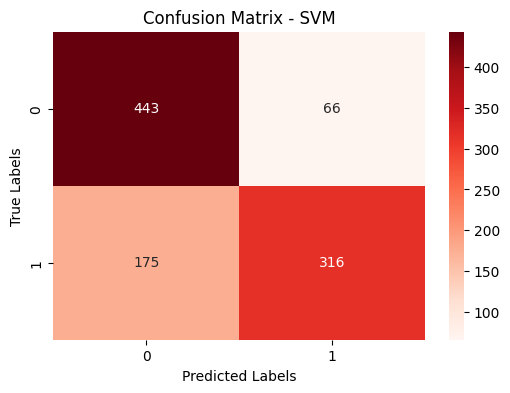

In [ ]:
y_preds = svm.predict(X_test)
cm = confusion_matrix(y_test, y_preds)

# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
X_test, y_test = text_to_w2v(val_df, w2v_model, "text", "label")

y_preds = svm.predict(X_test)

# Calculate accuracy and print classification report
accuracy = accuracy_score(y_test, y_preds)
report = classification_report(y_test, y_preds)

print(report)
print("SVM, Validation Accuracy Score:", accuracy)

              precision    recall  f1-score   support

           0       0.59      0.83      0.69       103
           1       0.47      0.20      0.28        74

    accuracy                           0.57       177
   macro avg       0.53      0.52      0.49       177
weighted avg       0.54      0.57      0.52       177

SVM, Validation Accuracy Score: 0.5706214689265536


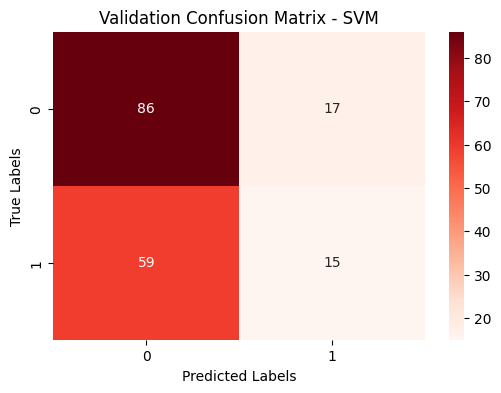

In [ ]:
y_preds = svm.predict(X_test)
cm = confusion_matrix(y_test, y_preds)

# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.title("Validation Confusion Matrix - SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
X_test, y_test = text_to_w2v(chan, w2v_model, "text", "label")

y_preds = svm.predict(X_test)

# Calculate accuracy and print classification report
accuracy = accuracy_score(y_test, y_preds)
report = classification_report(y_test, y_preds)

print(report)
print("SVM, 4chan Accuracy Score:", accuracy)

              precision    recall  f1-score   support

           0       0.24      0.72      0.36       177
           1       0.82      0.35      0.49       632

    accuracy                           0.43       809
   macro avg       0.53      0.53      0.42       809
weighted avg       0.69      0.43      0.46       809

SVM, 4chan Accuracy Score: 0.4289245982694685


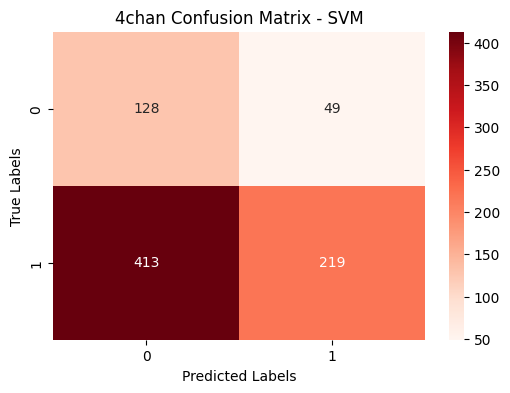

In [ ]:
y_preds = svm.predict(X_test)
cm = confusion_matrix(y_test, y_preds)

# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.title("4chan Confusion Matrix - SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## BERT training

In [143]:
torch.cuda.empty_cache()
gc.collect()

Training:   7%|▋         | 35/487 [1:00:32<13:01:48, 103.78s/it]


103791

In [ ]:
import torch
from torch.cuda.amp import autocast, GradScaler
from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import DataLoader, SequentialSampler, TensorDataset
from sklearn.metrics import classification_report
import gc
import logging

In [ ]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import logging
from datetime import datetime
from tqdm import tqdm
import gc
from sklearn.metrics import precision_recall_fscore_support
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler, BertModel, DataCollatorForLanguageModeling
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
import random
from sklearn.model_selection import train_test_split
from datasets import Dataset
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

def create_dataset_and_loaders(
    input_ids,
    attention_masks,
    embeddings,  # Keep embeddings parameter
    labels,
    batch_size=32,
    is_train=True
):
    """Create dataset and dataloader from encoded inputs"""
    # Create dataset with all tensors including embeddings
    dataset = TensorDataset(input_ids, attention_masks, embeddings, labels)

    sampler = RandomSampler(dataset) if is_train else SequentialSampler(dataset)

    dataloader = DataLoader(
        dataset,
        sampler=sampler,
        batch_size=batch_size
    )

    return dataloader

labels = torch.tensor(df_posts["gold_label"].values).to(device)

# Create training dataloader
train_dataloader = create_dataset_and_loaders(
    input_ids,
    attention_masks,
    embeddings,
    labels,
    batch_size=32,
    is_train=True
)

labels = torch.tensor(df_posts["gold_label"].values).to(device)

# Create training dataloader
train_dataloader = create_dataset_and_loaders(
    input_ids,
    attention_masks,
    embeddings,
    labels,
    batch_size=32,
    is_train=True
)

slur_labels = torch.tensor(slur_test["gold_label"].values).to(device)
slur_dataloader = create_dataset_and_loaders(
    slur_input_ids,
    slur_attention_masks,
    slur_embeddings,
    slur_labels,
    batch_size=32,
    is_train=False
)

val_labels = torch.tensor(val_df["label"].values).to(device)
val_dataloader = create_dataset_and_loaders(
    val_input_ids,
    val_attention_masks,
    val_embeddings,
    val_labels,
    batch_size=32,
    is_train=False
)

chan_labels = torch.tensor(chan["label"].values).to(device)
chan_dataloader = create_dataset_and_loaders(
    chan_input_ids,
    chan_attention_masks,
    chan_embeddings,
    chan_labels,
    batch_size=32,
    is_train=False
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/10


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Average training loss: 0.160
Average validation loss: 0.701
Validation F1 Score: 0.430
New best model saved!

Epoch 2/10


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Average training loss: 0.104
Average validation loss: 0.859
Validation F1 Score: 0.423

Epoch 3/10


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Average training loss: 0.071
Average validation loss: 0.959
Validation F1 Score: 0.428

Epoch 4/10


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Average training loss: 0.060
Average validation loss: 1.050
Validation F1 Score: 0.441
New best model saved!

Epoch 5/10


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Average training loss: 0.047
Average validation loss: 1.075
Validation F1 Score: 0.438

Epoch 6/10


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Average training loss: 0.034
Average validation loss: 1.042
Validation F1 Score: 0.441

Epoch 7/10


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Average training loss: 0.023
Average validation loss: 1.038
Validation F1 Score: 0.447
New best model saved!

Epoch 8/10


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Average training loss: 0.017
Average validation loss: 1.121
Validation F1 Score: 0.444

Epoch 9/10


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Average training loss: 0.010
Average validation loss: 1.143
Validation F1 Score: 0.444

Epoch 10/10


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Average training loss: 0.008
Average validation loss: 1.253
Validation F1 Score: 0.482
New best model saved!


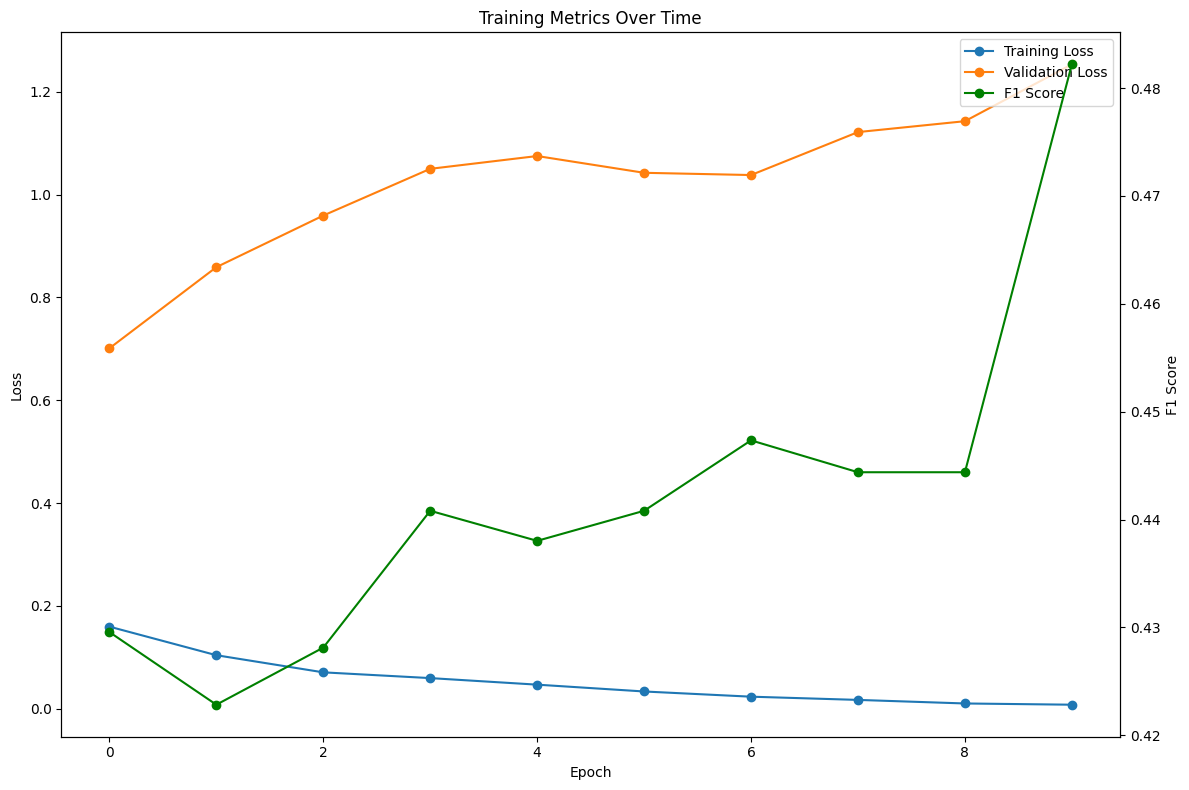

In [144]:
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, precision_recall_fscore_support
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import gc
from torch.cuda.amp import autocast, GradScaler

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_bert_classifier(
    model,
    train_dataloader,
    val_dataloader,
    device,
    num_epochs=5,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    max_grad_norm=1.0,
    use_wandb=False
):
    """
    Training function for BERT text classifier with pre-encoded inputs and embeddings
    """
    # Initialize optimizer with weight decay
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {
            'params': [p for n, p in model.named_parameters()
                      if not any(nd in n for nd in no_decay)],
            'weight_decay': weight_decay
        },
        {
            'params': [p for n, p in model.named_parameters()
                      if any(nd in n for nd in no_decay)],
            'weight_decay': 0.0
        }
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

    # Calculate total steps and setup scheduler
    total_steps = len(train_dataloader) * num_epochs
    warmup_steps = int(total_steps * warmup_ratio)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    # Initialize trackers and early stopping
    scaler = GradScaler()
    early_stopping = EarlyStopping(patience=3)
    best_val_f1 = 0
    best_model = None
    training_stats = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        # Training phase
        model.train()
        total_train_loss = 0
        optimizer.zero_grad()

        progress_bar = tqdm(train_dataloader, desc='Training', leave=True)
        for step, batch in enumerate(progress_bar):
            # Move batch to device and unpack all 4 tensors
            input_ids, attention_mask, embeddings, labels = [b.to(device) for b in batch]

            # Forward pass with mixed precision
            with autocast():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                loss = outputs.loss / 4  # Gradient accumulation steps

            # Backward pass with gradient scaling
            scaler.scale(loss).backward()

            total_train_loss += loss.item()

            # Gradient accumulation
            if (step + 1) % 4 == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                optimizer.zero_grad()

            # Update progress bar
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})

        avg_train_loss = total_train_loss / len(train_dataloader)

        # Validation phase
        model.eval()
        total_eval_loss = 0
        predictions = []
        true_labels = []

        for batch in tqdm(val_dataloader, desc='Validation', leave=True):
            # Unpack all 4 tensors for validation as well
            input_ids, attention_mask, embeddings, labels = [b.to(device) for b in batch]

            with torch.no_grad():
                with autocast():
                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels
                    )

            loss = outputs.loss
            logits = outputs.logits

            total_eval_loss += loss.item()
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_eval_loss / len(val_dataloader)

        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, predictions, average='weighted'
        )

        # Store statistics
        training_stats.append({
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. F1': f1,
        })

        # Print progress
        print(f"\nAverage training loss: {avg_train_loss:.3f}")
        print(f"Average validation loss: {avg_val_loss:.3f}")
        print(f"Validation F1 Score: {f1:.3f}")

        # Save best model
        if f1 > best_val_f1:
            best_val_f1 = f1
            best_model = model
            print("New best model saved!")

        # Clear memory
        torch.cuda.empty_cache()
        gc.collect()

    return best_model, training_stats

def plot_training_metrics(training_stats):
    """Plot training and validation metrics"""
    stats_df = pd.DataFrame(training_stats)

    # Create figure with secondary y-axis
    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax2 = ax1.twinx()

    # Plot training and validation loss on primary axis
    ax1.plot(stats_df['Training Loss'], label='Training Loss', marker='o')
    ax1.plot(stats_df['Valid. Loss'], label='Validation Loss', marker='o')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    # Plot F1 score on secondary axis
    ax2.plot(stats_df['Valid. F1'], label='F1 Score', color='green', marker='o')
    ax2.set_ylabel('F1 Score')

    # Add legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.title('Training Metrics Over Time')
    plt.tight_layout()
    plt.show()

# Usage example:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)
model.to(device)

# Train the model
model, training_stats = train_bert_classifier(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    num_epochs=10,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
)

# Plot training metrics
plot_training_metrics(training_stats)

In [145]:
torch.cuda.empty_cache()
gc.collect()

6468

In [146]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    roc_curve,
    auc,
    confusion_matrix,
    f1_score,
    accuracy_score
)
from typing import Tuple, Dict, Any
import torch.nn.functional as F

def evaluate_model(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device: torch.device,
    class_names: list = ['Class 0', 'Class 1']
) -> Tuple[float, Dict[str, Any]]:
    """
    Comprehensive model evaluation with metrics and visualizations.

    Args:
        model: The BERT model to evaluate
        dataloader: DataLoader containing validation/test data
        device: Device to run evaluation on
        class_names: Names of the classes for visualization

    Returns:
        Tuple containing average loss and dictionary of metrics
    """
    model.eval()
    loss_total = 0
    all_probs = []
    all_preds = []
    all_labels = []

    # Evaluation loop
    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2]
            }

            # Forward pass
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits

            # Get probabilities and predictions
            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)

            # Accumulate results
            loss_total += loss.item()
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(inputs['labels'].cpu().numpy())

    # Calculate average loss
    avg_loss = loss_total / len(dataloader)

    # Convert lists to numpy arrays
    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate metrics
    metrics = calculate_metrics(all_probs, all_preds, all_labels, class_names)

    # Generate visualizations
    plot_metrics(all_probs, all_preds, all_labels, class_names)

    return avg_loss, metrics

def calculate_metrics(probs: np.ndarray, preds: np.ndarray, labels: np.ndarray, class_names: list) -> Dict[str, Any]:
    """Calculate various classification metrics"""
    metrics = {}

    # Basic metrics
    metrics['accuracy'] = accuracy_score(labels, preds)
    metrics['f1_weighted'] = f1_score(labels, preds, average='weighted')
    metrics['f1_macro'] = f1_score(labels, preds, average='macro')

    # Classification report
    metrics['classification_report'] = classification_report(
        labels, preds,
        target_names=class_names,
        digits=4
    )

    # ROC AUC (for binary classification)
    if len(class_names) == 2:
        metrics['roc_auc'] = auc(
            *roc_curve(labels, probs[:, 1])[:2]
        )

    # Confusion Matrix
    metrics['confusion_matrix'] = confusion_matrix(labels, preds)

    return metrics

def plot_metrics(probs: np.ndarray, preds: np.ndarray, labels: np.ndarray, class_names: list):
    """Generate and display evaluation plots"""
    # Set up the plotting area
    fig = plt.figure(figsize=(20, 6))

    # 1. ROC Curve (if binary classification)
    if len(class_names) == 2:
        ax1 = fig.add_subplot(131)
        fpr, tpr, _ = roc_curve(labels, probs[:, 1])
        roc_auc = auc(fpr, tpr)

        ax1.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {roc_auc:.3f})')
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([0.0, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title('Receiver Operating Characteristic')
        ax1.legend(loc="lower right")

    # 2. Confusion Matrix Heatmap
    ax2 = fig.add_subplot(132)
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('True')
    ax2.set_title('Confusion Matrix')

    # 3. Prediction Distribution
    ax3 = fig.add_subplot(133)
    for i, class_name in enumerate(class_names):
        class_probs = probs[labels == i][:, i]
        sns.kdeplot(data=class_probs, label=class_name)
    ax3.set_xlabel('Prediction Probability')
    ax3.set_ylabel('Density')
    ax3.set_title('Prediction Probability Distribution')
    ax3.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
def print_metrics(metrics: Dict[str, Any]):
    """Print evaluation metrics in a formatted way"""
    print("\n=== Model Evaluation Results ===")
    print("\nClassification Report:")
    print(metrics['classification_report'])

    print("\nOverall Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Weighted F1: {metrics['f1_weighted']:.4f}")
    print(f"Macro F1: {metrics['f1_macro']:.4f}")

    if 'roc_auc' in metrics:
        print(f"ROC AUC: {metrics['roc_auc']:.4f}")

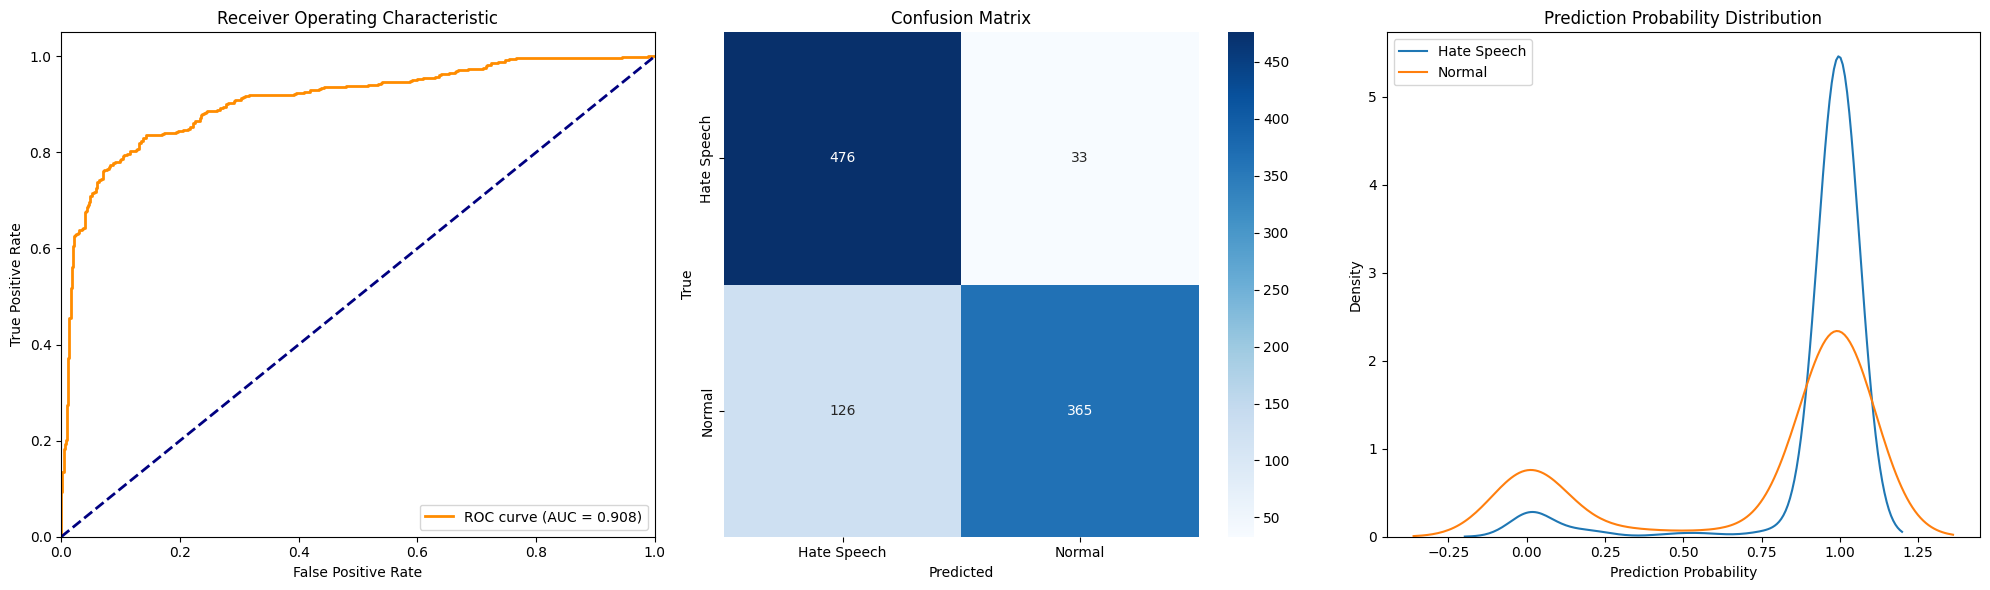


=== Model Evaluation Results ===

Classification Report:
              precision    recall  f1-score   support

 Hate Speech     0.7907    0.9352    0.8569       509
      Normal     0.9171    0.7434    0.8211       491

    accuracy                         0.8410      1000
   macro avg     0.8539    0.8393    0.8390      1000
weighted avg     0.8528    0.8410    0.8393      1000


Overall Metrics:
Accuracy: 0.8410
Weighted F1: 0.8393
Macro F1: 0.8390
ROC AUC: 0.9082


In [147]:
def evaluate_model(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device: torch.device,
    class_names: list = ['Class 0', 'Class 1']
) -> Tuple[float, Dict[str, Any]]:
    """
    Comprehensive model evaluation with metrics and visualizations.

    Args:
        model: The BERT model to evaluate
        dataloader: DataLoader containing validation/test data
        device: Device to run evaluation on
        class_names: Names of the classes for visualization

    Returns:
        Tuple containing average loss and dictionary of metrics
    """
    model.eval()
    loss_total = 0
    all_probs = []
    all_preds = []
    all_labels = []

    # Evaluation loop
    with torch.no_grad():
        for batch in dataloader:
            # Unpack all 4 tensors from the batch
            input_ids, attention_mask, embeddings, labels = tuple(b.to(device) for b in batch)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits

            # Get probabilities and predictions
            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)

            # Accumulate results
            loss_total += loss.item()
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss
    avg_loss = loss_total / len(dataloader)

    # Convert lists to numpy arrays
    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate metrics
    metrics = calculate_metrics(all_probs, all_preds, all_labels, class_names)

    # Generate visualizations
    plot_metrics(all_probs, all_preds, all_labels, class_names)

    return avg_loss, metrics

# The calculate_metrics and plot_metrics functions remain the same

def print_metrics(metrics: Dict[str, Any]):
    """Print evaluation metrics in a formatted way"""
    print("\n=== Model Evaluation Results ===")
    print("\nClassification Report:")
    print(metrics['classification_report'])

    print("\nOverall Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Weighted F1: {metrics['f1_weighted']:.4f}")
    print(f"Macro F1: {metrics['f1_macro']:.4f}")

    if 'roc_auc' in metrics:
        print(f"ROC AUC: {metrics['roc_auc']:.4f}")

# Usage example
avg_loss, metrics = evaluate_model(
    model=model,
    dataloader=slur_dataloader,
    device=device,
    class_names=['Hate Speech', 'Normal']
)

print_metrics(metrics)

In [148]:
torch.cuda.empty_cache()
gc.collect()

153

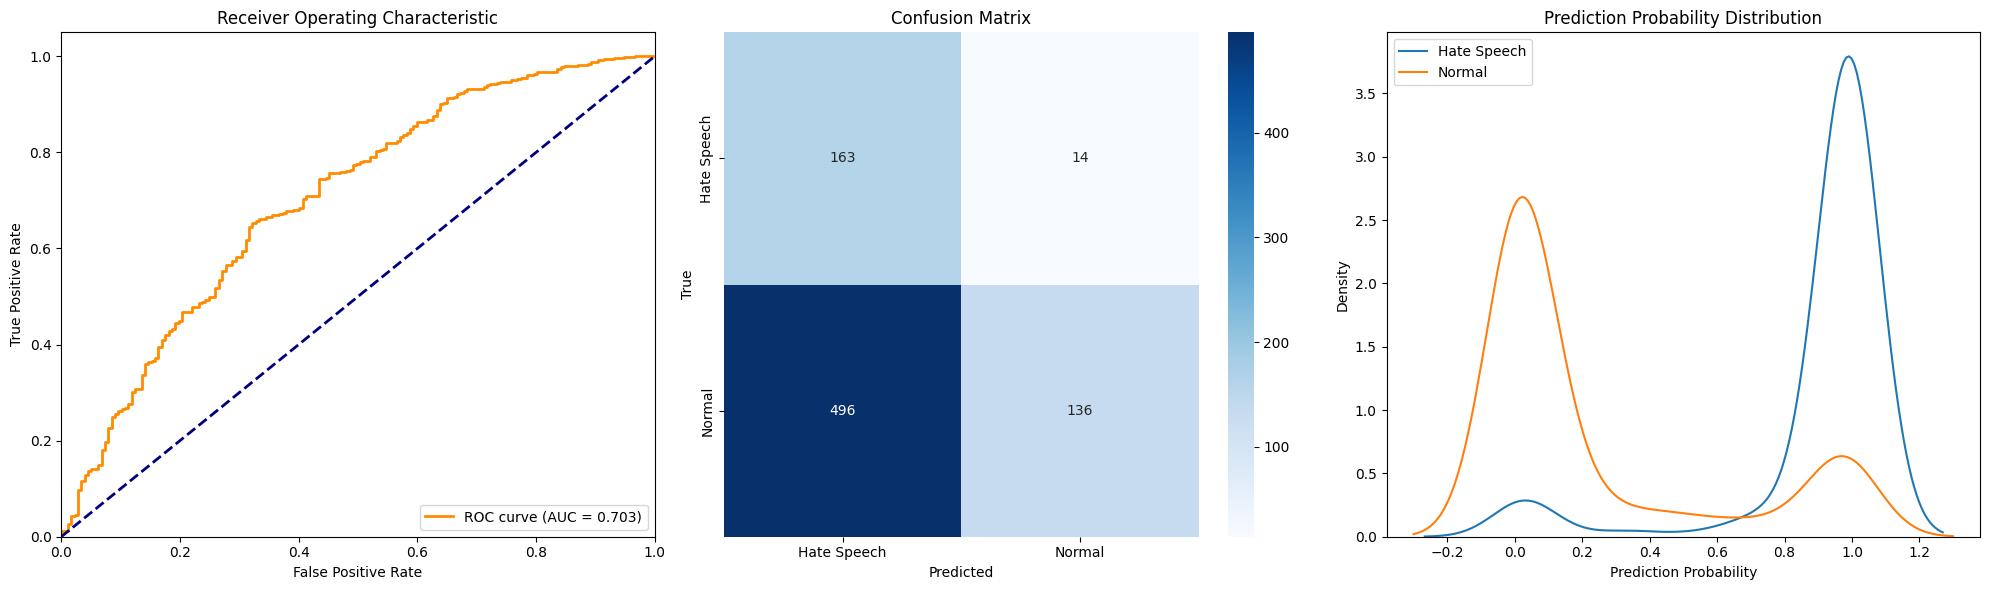


=== Model Evaluation Results ===

Classification Report:
              precision    recall  f1-score   support

 Hate Speech     0.2473    0.9209    0.3900       177
      Normal     0.9067    0.2152    0.3478       632

    accuracy                         0.3696       809
   macro avg     0.5770    0.5680    0.3689       809
weighted avg     0.7624    0.3696    0.3570       809


Overall Metrics:
Accuracy: 0.3696
Weighted F1: 0.3570
Macro F1: 0.3689
ROC AUC: 0.7028


In [149]:
model.eval()
avg_loss, metrics = evaluate_model(
    model=model,
    dataloader=chan_dataloader,
    device=device,
    class_names=['Hate Speech', 'Normal']  # Replace with your class names
)

print_metrics(metrics)

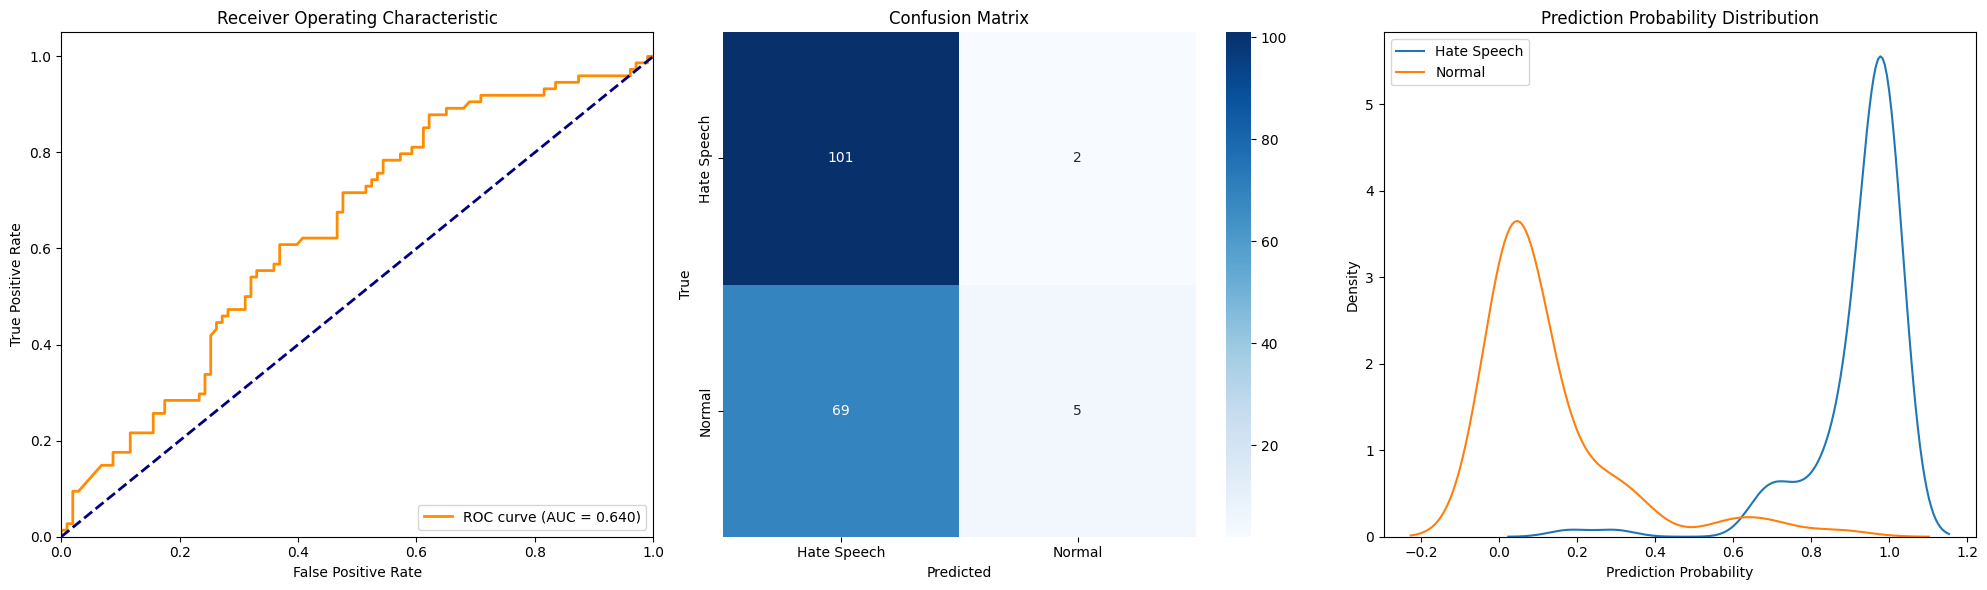


=== Model Evaluation Results ===

Classification Report:
              precision    recall  f1-score   support

 Hate Speech     0.5941    0.9806    0.7399       103
      Normal     0.7143    0.0676    0.1235        74

    accuracy                         0.5989       177
   macro avg     0.6542    0.5241    0.4317       177
weighted avg     0.6444    0.5989    0.4822       177


Overall Metrics:
Accuracy: 0.5989
Weighted F1: 0.4822
Macro F1: 0.4317
ROC AUC: 0.6398


In [150]:
model.eval()
avg_loss, metrics = evaluate_model(
    model=model,
    dataloader=val_dataloader,
    device=device,
    class_names=['Hate Speech', 'Normal']  # Replace with your class names
)

print_metrics(metrics)

In [160]:
import torch
import numpy as np
from tqdm import tqdm

def get_predictions(model, dataloader, device):
    """
    Get predictions from a BERT model for a given dataloader.

    Args:
        model: The BERT model
        dataloader: DataLoader containing the data
        device: Device to run predictions on

    Returns:
        predictions: Array of predicted classes
        probabilities: Array of prediction probabilities
        true_labels: Array of true labels (if available)
    """
    model.eval()
    predictions = []
    probabilities = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Getting predictions"):
            batch = tuple(b.to(device) for b in batch)

            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1]
            }

            # If labels are available in the dataloader
            if len(batch) > 2:
                true_labels.extend(batch[2].cpu().numpy())

            # Get predictions
            outputs = model(**inputs)
            logits = outputs.logits

            # Get probabilities
            probs = torch.nn.functional.softmax(logits, dim=1)

            # Store predictions and probabilities
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    predictions = np.array(predictions)
    probabilities = np.array(probabilities)
    true_labels = np.array(true_labels) if true_labels else None

    return predictions, probabilities, true_labels

preds, probs, labels = get_predictions(
    model=model,
    dataloader=val_dataloader,
    device=device
)

# Access predictions
print("Predictions shape:", preds.shape)
print("Probabilities shape:", probs.shape)


Getting predictions: 100%|██████████| 6/6 [00:01<00:00,  5.22it/s]

Predictions shape: (177,)
Probabilities shape: (177, 2)


In [152]:
# Move tensors to CPU and convert to lists if they are tensors
val_labels = val_labels.cpu().numpy() if isinstance(val_labels, torch.Tensor) else val_labels
preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds

# Create DataFrame
val_hrg = pd.DataFrame({
    'Text': val_df['text'],
    'Og labels': val_labels,
    'Predictions': preds
})

# Save to CSV
val_hrg.to_csv('bert_hsexpert.csv', index=False)


In [158]:
torch.cuda.empty_cache()
gc.collect()

0

## BERT with sarcasm head

In [ ]:
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
sarcasm_labels = torch.tensor(sarcasm_df["label"].values).to(device)
original_dataloader = create_dataset_and_loaders(
    sarc_input_ids,
    sarc_attention_masks,
    sarc_embeddings,
    sarcasm_labels,
    batch_size=32,
    is_train=False
)

from torch.utils.data import DataLoader, random_split
dataset = original_dataloader.dataset

# Define the sizes for the splits
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create new DataLoaders for the train and test sets
sarcasm_train_dataloader = DataLoader(train_dataset, batch_size=original_dataloader.batch_size, shuffle=False)
sarcasm_test_dataloader = DataLoader(test_dataset, batch_size=original_dataloader.batch_size, shuffle=False)

In [ ]:
from torch import nn


Epoch 1/10



Training: 100%|██████████| 487/487 [04:59<00:00,  1.63it/s]


Validating task 1...



100%|██████████| 32/32 [00:06<00:00,  5.07it/s]


Validating task 2...



100%|██████████| 44/44 [00:08<00:00,  5.02it/s]



Average training loss: 0.470
Average validation loss: 0.682
Task 1 F1 Score: 0.691
Task 2 F1 Score: 0.508
New best model saved!

Epoch 2/10



Training: 100%|██████████| 487/487 [04:58<00:00,  1.63it/s]


Validating task 1...



100%|██████████| 32/32 [00:06<00:00,  5.06it/s]


Validating task 2...



100%|██████████| 44/44 [00:08<00:00,  5.03it/s]



Average training loss: 0.396
Average validation loss: 0.591
Task 1 F1 Score: 0.815
Task 2 F1 Score: 0.492
New best model saved!

Epoch 3/10



Training: 100%|██████████| 487/487 [04:58<00:00,  1.63it/s]


Validating task 1...



100%|██████████| 32/32 [00:06<00:00,  5.08it/s]


Validating task 2...



100%|██████████| 44/44 [00:08<00:00,  5.02it/s]



Average training loss: 0.343
Average validation loss: 1.014
Task 1 F1 Score: 0.559
Task 2 F1 Score: 0.461

Epoch 4/10



Training: 100%|██████████| 487/487 [04:58<00:00,  1.63it/s]


Validating task 1...



100%|██████████| 32/32 [00:06<00:00,  5.08it/s]


Validating task 2...



100%|██████████| 44/44 [00:08<00:00,  5.03it/s]



Average training loss: 0.306
Average validation loss: 1.123
Task 1 F1 Score: 0.472
Task 2 F1 Score: 0.441

Epoch 5/10



Training: 100%|██████████| 487/487 [04:58<00:00,  1.63it/s]


Validating task 1...



100%|██████████| 32/32 [00:06<00:00,  5.08it/s]


Validating task 2...



100%|██████████| 44/44 [00:08<00:00,  5.04it/s]



Average training loss: 0.278
Average validation loss: 1.287
Task 1 F1 Score: 0.586
Task 2 F1 Score: 0.420

Epoch 6/10



Training: 100%|██████████| 487/487 [04:58<00:00,  1.63it/s]


Validating task 1...



100%|██████████| 32/32 [00:06<00:00,  5.07it/s]


Validating task 2...



100%|██████████| 44/44 [00:08<00:00,  5.02it/s]



Average training loss: 0.252
Average validation loss: 1.099
Task 1 F1 Score: 0.742
Task 2 F1 Score: 0.410

Epoch 7/10



Training: 100%|██████████| 487/487 [04:58<00:00,  1.63it/s]


Validating task 1...



100%|██████████| 32/32 [00:06<00:00,  5.07it/s]


Validating task 2...



100%|██████████| 44/44 [00:08<00:00,  5.03it/s]



Average training loss: 0.214
Average validation loss: 1.170
Task 1 F1 Score: 0.765
Task 2 F1 Score: 0.430

Epoch 8/10



Training: 100%|██████████| 487/487 [04:58<00:00,  1.63it/s]


Validating task 1...



100%|██████████| 32/32 [00:06<00:00,  5.07it/s]


Validating task 2...



100%|██████████| 44/44 [00:08<00:00,  5.03it/s]



Average training loss: 0.195
Average validation loss: 1.022
Task 1 F1 Score: 0.794
Task 2 F1 Score: 0.433

Epoch 9/10



Training: 100%|██████████| 487/487 [04:58<00:00,  1.63it/s]


Validating task 1...



100%|██████████| 32/32 [00:06<00:00,  5.07it/s]


Validating task 2...



100%|██████████| 44/44 [00:08<00:00,  5.02it/s]



Average training loss: 0.188
Average validation loss: 1.039
Task 1 F1 Score: 0.784
Task 2 F1 Score: 0.433

Epoch 10/10



Training: 100%|██████████| 487/487 [04:58<00:00,  1.63it/s]


Validating task 1...



100%|██████████| 32/32 [00:06<00:00,  5.07it/s]


Validating task 2...



100%|██████████| 44/44 [00:08<00:00,  5.02it/s]



Average training loss: 0.179
Average validation loss: 1.370
Task 1 F1 Score: 0.801
Task 2 F1 Score: 0.428


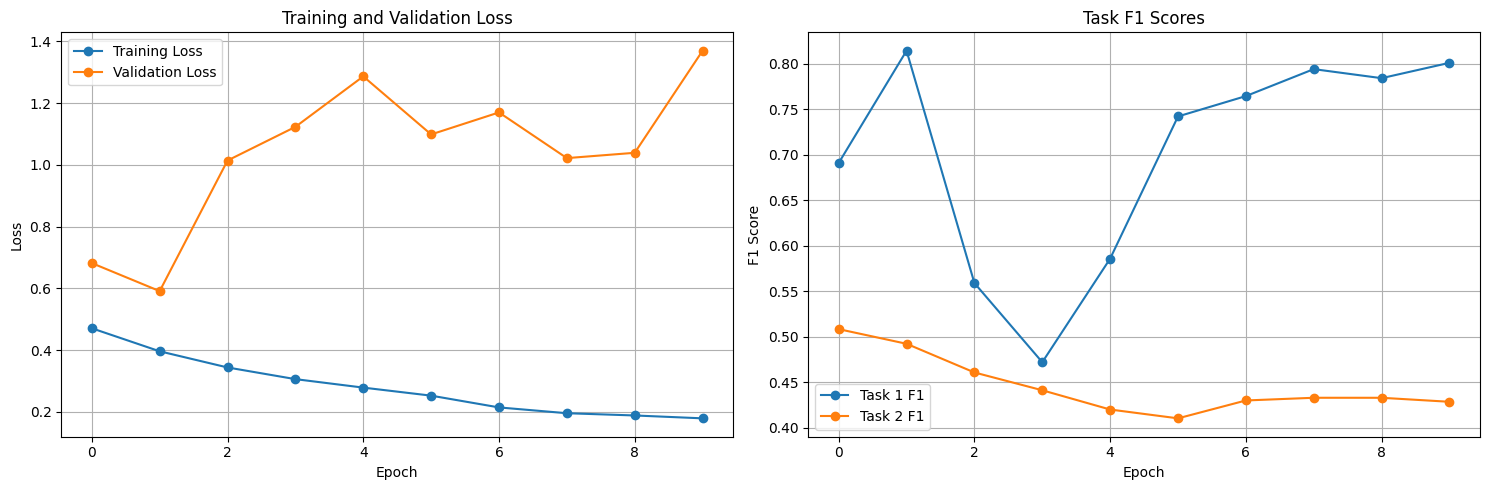

In [134]:
def train_multitask_bert(
    model,
    train_dataloader1,
    val_dataloader1,
    train_dataloader2,
    val_dataloader2,
    device,
    num_epochs=5,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01
):
    """
    Train the multi-task BERT model
    """
    # Initialize optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Training statistics
    best_val_f1 = 0
    training_stats = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        # Training phase
        model.train()
        total_train_loss = 0

        # Combine progress from both tasks
        combined_len = len(train_dataloader1) + len(train_dataloader2)
        progress_bar = tqdm(total=combined_len, desc='Training')

        # Train on task 1
        for batch in train_dataloader1:
            # Unpack batch tuple
            input_ids, attention_mask, embeddings, labels = [b.to(device) for b in batch]

            optimizer.zero_grad()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                task_id=1
            )

            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_train_loss += loss.item()
            progress_bar.update(1)

        # Train on task 2 (sarcasm)
        for batch in train_dataloader2:
            # Unpack batch tuple
            input_ids, attention_mask, embeddings, labels = [b.to(device) for b in batch]

            optimizer.zero_grad()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                task_id=2
            )

            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_train_loss += loss.item()
            progress_bar.update(1)

        progress_bar.close()
        avg_train_loss = total_train_loss / combined_len

        # Validation phase
        model.eval()
        val_loss = 0
        predictions1, true_labels1 = [], []
        predictions2, true_labels2 = [], []

        print("Validating task 1...")
        for batch in tqdm(val_dataloader1):
            # Unpack batch tuple
            input_ids, attention_mask, embeddings, labels = [b.to(device) for b in batch]

            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    task_id=1
                )

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predictions1.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            true_labels1.extend(labels.cpu().numpy())

        print("Validating task 2...")
        for batch in tqdm(val_dataloader2):
            # Unpack batch tuple
            input_ids, attention_mask, embeddings, labels = [b.to(device) for b in batch]

            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    task_id=2
                )

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predictions2.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            true_labels2.extend(labels.cpu().numpy())

        # Calculate metrics
        f1_task1 = f1_score(true_labels1, predictions1, average='weighted')
        f1_task2 = f1_score(true_labels2, predictions2, average='weighted')
        avg_val_loss = val_loss / (len(val_dataloader1) + len(val_dataloader2))

        # Store statistics
        training_stats.append({
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Task1 F1': f1_task1,
            'Task2 F1': f1_task2
        })

        print(f"\nAverage training loss: {avg_train_loss:.3f}")
        print(f"Average validation loss: {avg_val_loss:.3f}")
        print(f"Task 1 F1 Score: {f1_task1:.3f}")
        print(f"Task 2 F1 Score: {f1_task2:.3f}")

        # Save best model based on average F1 score
        avg_f1 = (f1_task1 + f1_task2) / 2
        if avg_f1 > best_val_f1:
            best_val_f1 = avg_f1
            best_model = model
            print("New best model saved!")

        # Clear memory
        torch.cuda.empty_cache()

    return best_model, training_stats

def plot_training_metrics(training_stats):
    """Plot training metrics over time"""
    stats_df = pd.DataFrame(training_stats)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(stats_df['Training Loss'], label='Training Loss', marker='o')
    ax1.plot(stats_df['Valid. Loss'], label='Validation Loss', marker='o')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot F1 scores
    ax2.plot(stats_df['Task1 F1'], label='Task 1 F1', marker='o')
    ax2.plot(stats_df['Task2 F1'], label='Task 2 F1', marker='o')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.set_title('Task F1 Scores')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Initialize and train the model
model = MultitaskBERT(
    num_labels_task1=2,  # Original classification task
    num_labels_task2=2   # Sarcasm detection (binary)
)
model.to(device)

# Train the model
model, training_stats = train_multitask_bert(
    model=model,
    train_dataloader1=train_dataloader,
    val_dataloader1=slur_dataloader,
    train_dataloader2=sarcasm_train_dataloader,
    val_dataloader2=sarcasm_test_dataloader,
    device=device,
    num_epochs=10
)

# Plot training metrics
plot_training_metrics(training_stats)

In [ ]:
torch.cuda.empty_cache()
gc.collect()

43


Getting predictions for Task 1: 100%|██████████| 6/6 [00:01<00:00,  5.37it/s]



Classification Report for Task 1 Classification:
              precision    recall  f1-score   support

           0       0.59      0.77      0.67       103
           1       0.45      0.27      0.34        74

    accuracy                           0.56       177
   macro avg       0.52      0.52      0.50       177
weighted avg       0.54      0.56      0.53       177



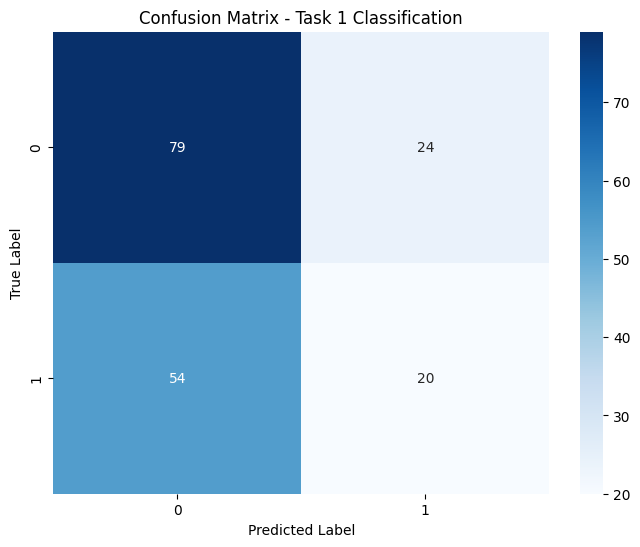

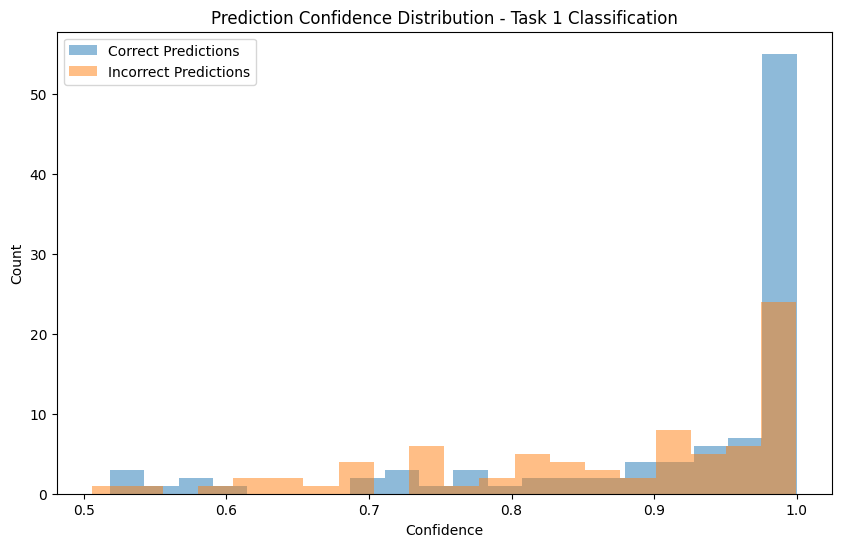

In [135]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def get_predictions_multitask(model, dataloader, device, task_id):
    """
    Get predictions from a multi-task BERT model for a specific task.
    """
    model.eval()
    predictions = []
    probabilities = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Getting predictions for Task {task_id}"):
            # Unpack the batch - ignore embeddings
            input_ids, attention_mask, _, labels = [b.to(device) for b in batch]

            # Get model outputs
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                task_id=task_id
            )

            # Get probabilities and predictions
            probs = torch.nn.functional.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            # Store predictions, probabilities, and true labels
            predictions.extend(preds.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    predictions = np.array(predictions)
    probabilities = np.array(probabilities)
    true_labels = np.array(true_labels)

    return predictions, probabilities, true_labels

def evaluate_predictions(predictions, true_labels, probabilities, task_name):
    """
    Evaluate predictions with detailed metrics and visualizations.
    """
    # Print classification report
    print(f"\nClassification Report for {task_name}:")
    print(classification_report(true_labels, predictions))

    # Create confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {task_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot prediction confidence distribution
    plt.figure(figsize=(10, 6))
    correct_probs = probabilities[predictions == true_labels].max(axis=1)
    incorrect_probs = probabilities[predictions != true_labels].max(axis=1)

    plt.hist(correct_probs, alpha=0.5, label='Correct Predictions', bins=20)
    if len(incorrect_probs) > 0:  # Only plot if there are incorrect predictions
        plt.hist(incorrect_probs, alpha=0.5, label='Incorrect Predictions', bins=20)
    plt.title(f'Prediction Confidence Distribution - {task_name}')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

def evaluate_model(model, test_dataloader, device, task_id=1, task_name=None):
    """
    Evaluate the multi-task model on a specific task.
    """
    if task_name is None:
        task_name = f"Task {task_id}"

    # Get predictions
    predictions, probabilities, true_labels = get_predictions_multitask(
        model=model,
        dataloader=test_dataloader,
        device=device,
        task_id=task_id
    )

    # Evaluate predictions
    evaluate_predictions(
        predictions=predictions,
        true_labels=true_labels,
        probabilities=probabilities,
        task_name=task_name
    )

    return predictions

# Evaluate the model
results_task1 = evaluate_model(
    model=model,
    test_dataloader=val_dataloader,
    device=device,
    task_id=1,
    task_name="Task 1 Classification"
)

In [139]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from typing import Tuple, Dict, List, Optional

def get_predictions_multitask(
    model: torch.nn.Module,
    dataloader: DataLoader,
    device: torch.device,
    task_id: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Get predictions from a multi-task BERT model for a specific task.

    Args:
        model: The multitask model
        dataloader: Single dataloader containing the evaluation data
        device: Device to run evaluation on
        task_id: Which task to evaluate

    Returns:
        Tuple of (predictions, probabilities, true_labels) as numpy arrays
    """
    model.eval()
    predictions = []
    probabilities = []
    true_labels = []
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Getting predictions for Task {task_id}"):
            # Unpack the batch - ignore embeddings
            input_ids, attention_mask, _, labels = [b.to(device) for b in batch]

            # Get model outputs
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                task_id=task_id
            )

            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Get probabilities and predictions
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            # Store results
            predictions.extend(preds.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    predictions = np.array(predictions)
    probabilities = np.array(probabilities)
    true_labels = np.array(true_labels)
    avg_loss = total_loss / len(dataloader)

    return predictions, probabilities, true_labels, avg_loss

def plot_roc_curve(true_labels: np.ndarray, probabilities: np.ndarray, task_name: str):
    """Plot ROC curve for binary classification"""
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {task_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def evaluate_predictions(
    predictions: np.ndarray,
    true_labels: np.ndarray,
    probabilities: np.ndarray,
    task_name: str,
    avg_loss: float,
    class_names: Optional[List[str]] = None
):
    """
    Evaluate predictions with detailed metrics and visualizations.

    Args:
        predictions: Model predictions
        true_labels: True labels
        probabilities: Prediction probabilities
        task_name: Name of the task for display
        avg_loss: Average loss during evaluation
        class_names: Optional list of class names for better visualization
    """
    if class_names is None:
        class_names = [f"Class {i}" for i in range(len(np.unique(true_labels)))]

    # Calculate metrics
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Print metrics
    print(f"\n{'='*20} {task_name} Results {'='*20}")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=class_names))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'Confusion Matrix - {task_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot ROC curve for binary classification
    if len(class_names) == 2:
        plot_roc_curve(true_labels, probabilities, task_name)

    # Plot prediction confidence distribution
    plt.figure(figsize=(10, 6))
    for i, class_name in enumerate(class_names):
        mask = true_labels == i
        class_probs = probabilities[mask][:, i]
        sns.kdeplot(data=class_probs, label=f'Class {class_name}')

    plt.title(f'Prediction Confidence Distribution - {task_name}')
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluate_model(
    model: torch.nn.Module,
    test_dataloader: DataLoader,
    device: torch.device,
    task_id: int = 1,
    task_name: Optional[str] = None,
    class_names: Optional[List[str]] = None
) -> Dict:
    """
    Evaluate the multi-task model on a specific task.

    Args:
        model: The multitask model
        test_dataloader: Single dataloader containing the evaluation data
        device: Device to run evaluation on
        task_id: Which task to evaluate
        task_name: Optional name for the task
        class_names: Optional list of class names

    Returns:
        Dictionary containing evaluation metrics
    """
    if task_name is None:
        task_name = f"Task {task_id}"

    # Get predictions
    predictions, probabilities, true_labels, avg_loss = get_predictions_multitask(
        model=model,
        dataloader=test_dataloader,
        device=device,
        task_id=task_id
    )

    # Evaluate predictions
    evaluate_predictions(
        predictions=predictions,
        true_labels=true_labels,
        probabilities=probabilities,
        task_name=task_name,
        avg_loss=avg_loss,
        class_names=class_names
    )

    # Return metrics dictionary
    return {
        'predictions': predictions,
        'probabilities': probabilities,
        'true_labels': true_labels,
        'avg_loss': avg_loss,
        'f1_score': f1_score(true_labels, predictions, average='weighted')
    }

# Example usage:
def evaluate_all_tasks(model, val_dataloader, device):
    """Helper function to evaluate all tasks"""
    task1_results = evaluate_model(
        model=model,
        test_dataloader=val_dataloader,
        device=device,
        task_id=1,
        task_name="Hate Speech Detection",
        class_names=['Non-hate', 'Hate']
    )

    task2_results = evaluate_model(
        model=model,
        test_dataloader=val_dataloader,
        device=device,
        task_id=2,
        task_name="Sarcasm Detection",
        class_names=['Non-sarcastic', 'Sarcastic']
    )

    return {
        'task1': task1_results,
        'task2': task2_results
    }


Getting predictions for Task 1: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]



==================== Hate Speech Detection Results ====================
Average Loss: 1.4265
F1 Score (weighted): 0.5313

Classification Report:
              precision    recall  f1-score   support

    Non-hate       0.59      0.77      0.67       103
        Hate       0.45      0.27      0.34        74

    accuracy                           0.56       177
   macro avg       0.52      0.52      0.50       177
weighted avg       0.54      0.56      0.53       177



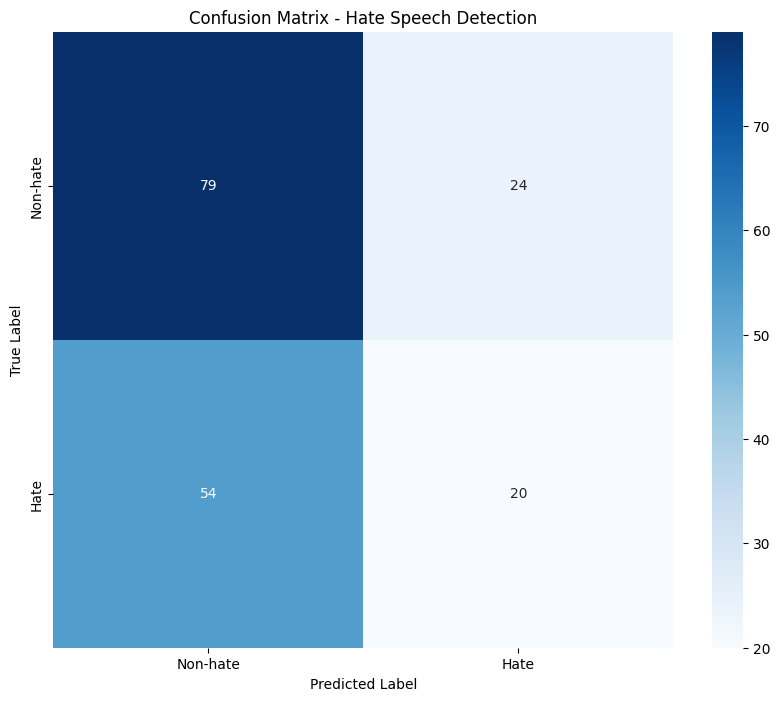

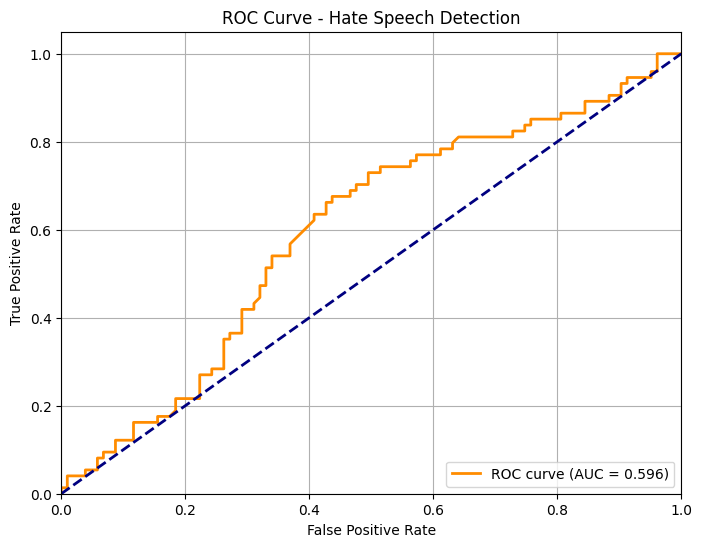

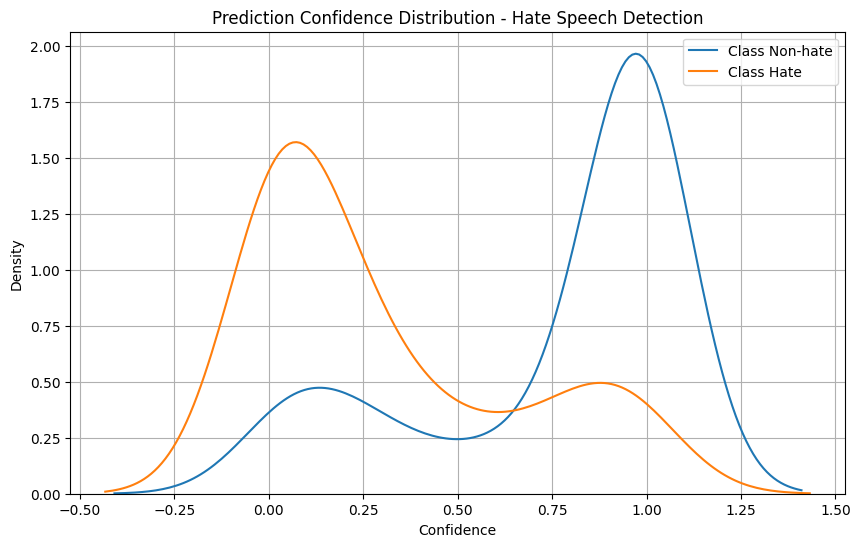


Getting predictions for Task 1: 100%|██████████| 6/6 [00:01<00:00,  5.25it/s]



==================== Hate Speech Detection Results ====================
Average Loss: 1.4265
F1 Score (weighted): 0.5313

Classification Report:
              precision    recall  f1-score   support

    Non-hate       0.59      0.77      0.67       103
        Hate       0.45      0.27      0.34        74

    accuracy                           0.56       177
   macro avg       0.52      0.52      0.50       177
weighted avg       0.54      0.56      0.53       177



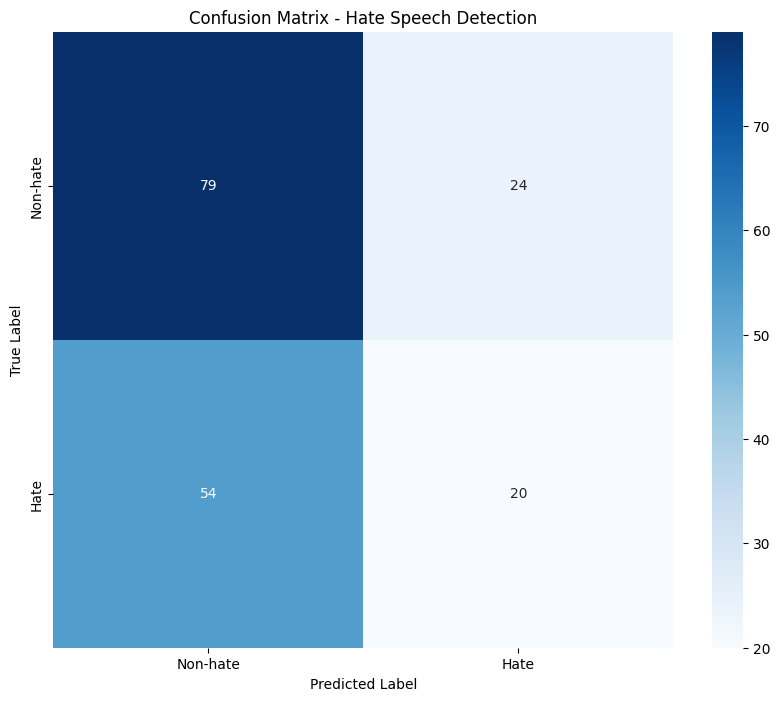

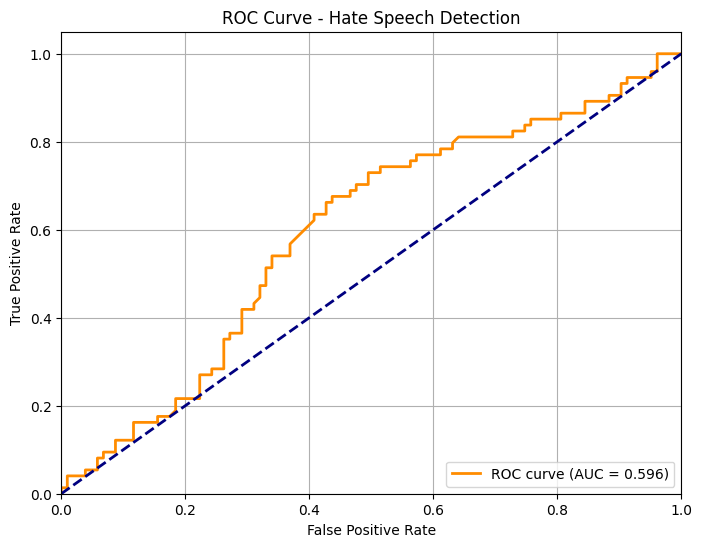

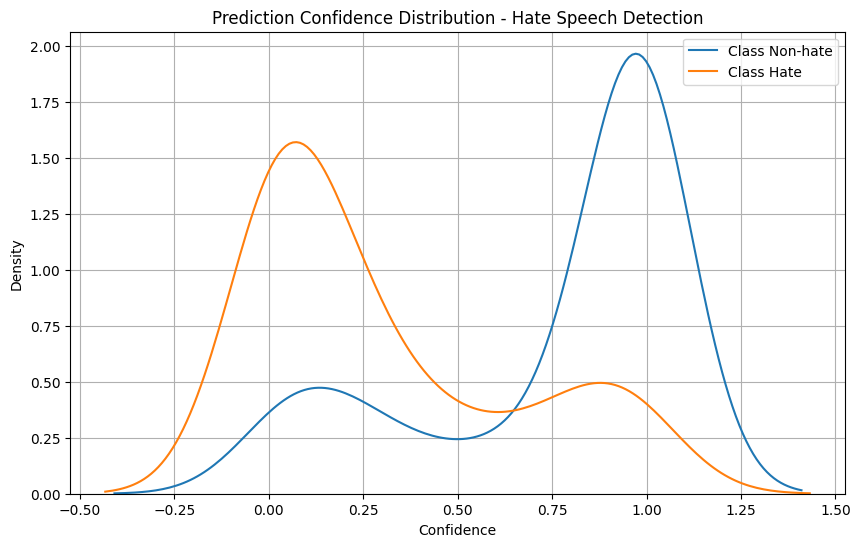


Getting predictions for Task 2: 100%|██████████| 6/6 [00:01<00:00,  5.25it/s]



==================== Sarcasm Detection Results ====================
Average Loss: 0.9689
F1 Score (weighted): 0.4549

Classification Report:
               precision    recall  f1-score   support

Non-sarcastic       0.54      0.43      0.48       103
    Sarcastic       0.38      0.49      0.43        74

     accuracy                           0.45       177
    macro avg       0.46      0.46      0.45       177
 weighted avg       0.47      0.45      0.45       177



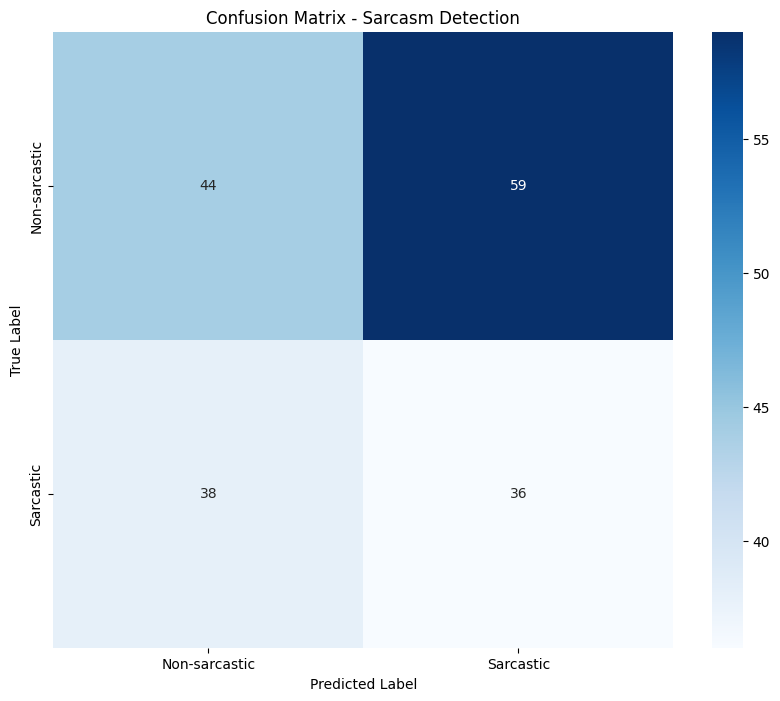

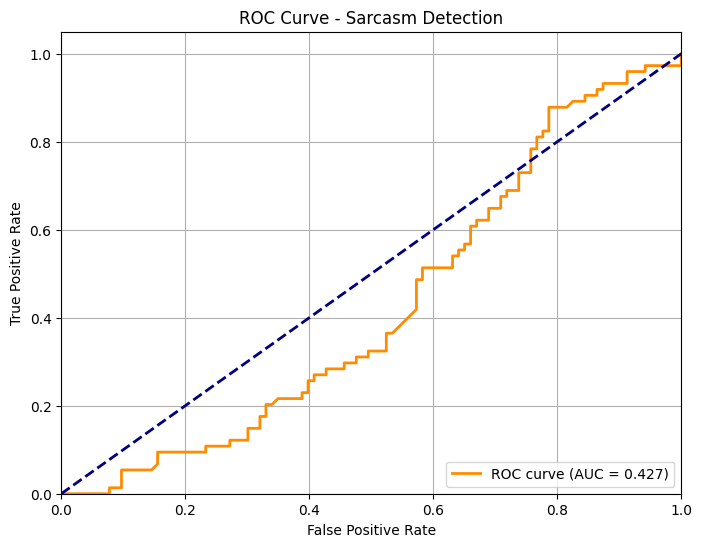

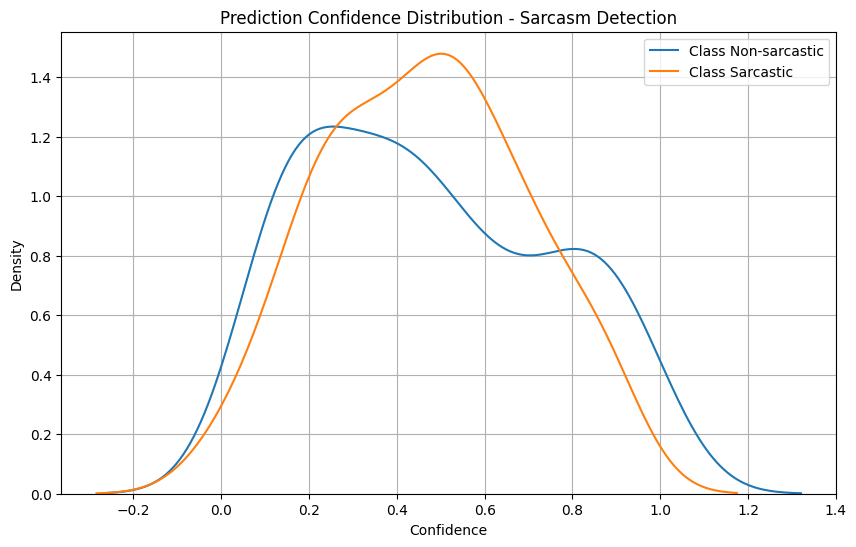

In [140]:
# Evaluate individual task
task1_results = evaluate_model(
    model=model,
    test_dataloader=val_dataloader,
    device=device,
    task_id=1,
    task_name="Hate Speech Detection",
    class_names=['Non-hate', 'Hate']
)

# Or evaluate all tasks at once
all_results = evaluate_all_tasks(model, val_dataloader, device)


Getting predictions for Task 1: 100%|██████████| 32/32 [00:06<00:00,  4.91it/s]



==================== Hate Speech Detection Results ====================
Average Loss: 1.1006
F1 Score (weighted): 0.8012

Classification Report:
              precision    recall  f1-score   support

    Non-hate       0.75      0.92      0.83       509
        Hate       0.89      0.69      0.78       491

    accuracy                           0.80      1000
   macro avg       0.82      0.80      0.80      1000
weighted avg       0.82      0.80      0.80      1000



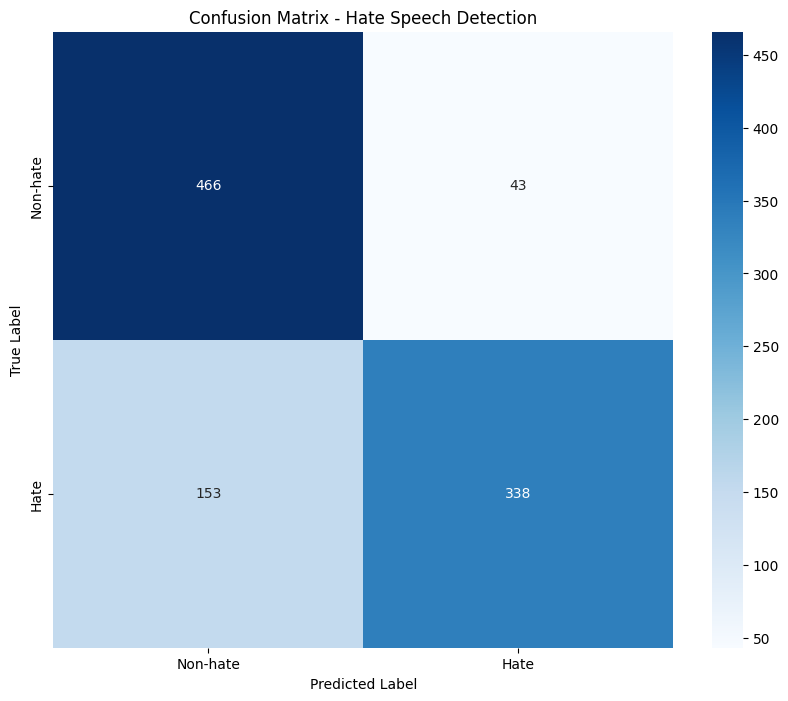

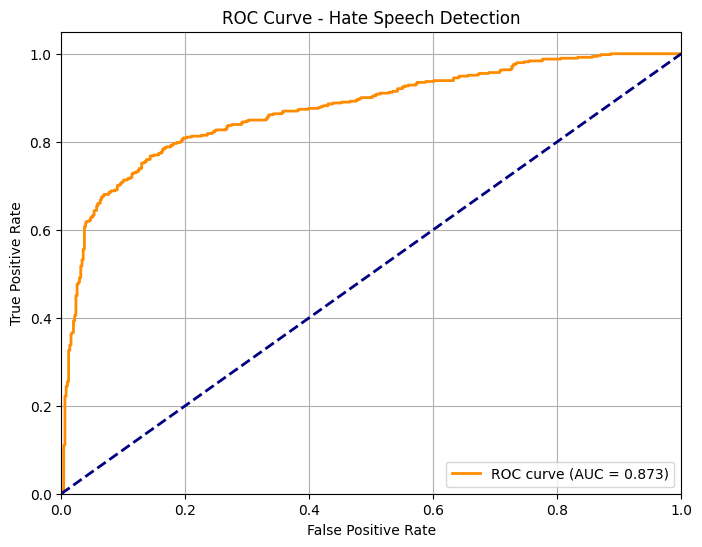

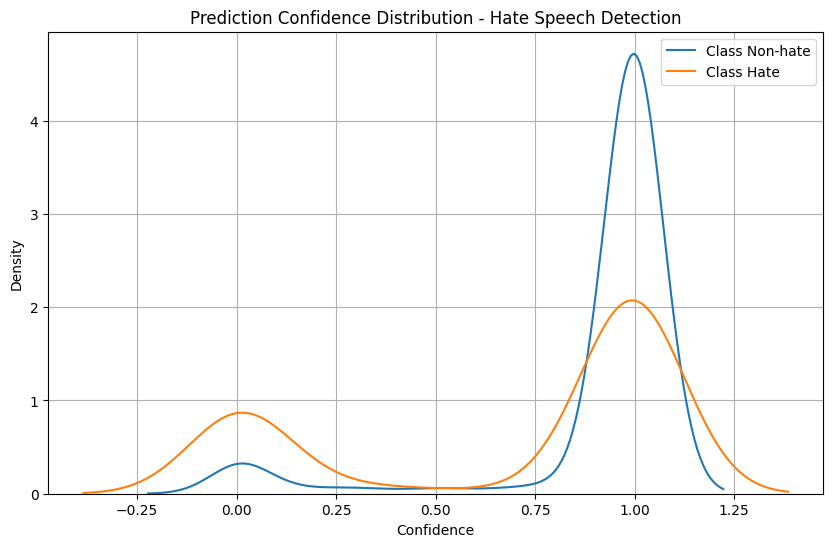


Getting predictions for Task 1: 100%|██████████| 6/6 [00:01<00:00,  5.24it/s]



==================== Hate Speech Detection Results ====================
Average Loss: 1.4265
F1 Score (weighted): 0.5313

Classification Report:
              precision    recall  f1-score   support

    Non-hate       0.59      0.77      0.67       103
        Hate       0.45      0.27      0.34        74

    accuracy                           0.56       177
   macro avg       0.52      0.52      0.50       177
weighted avg       0.54      0.56      0.53       177



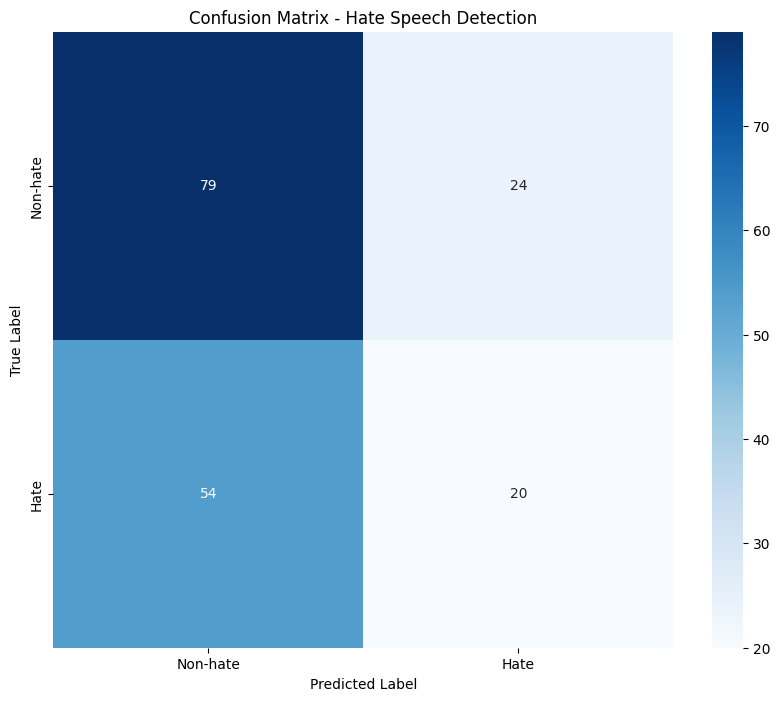

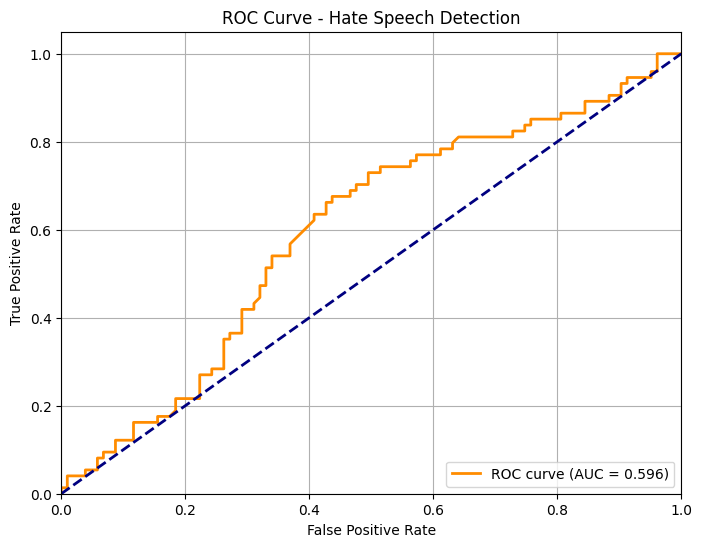

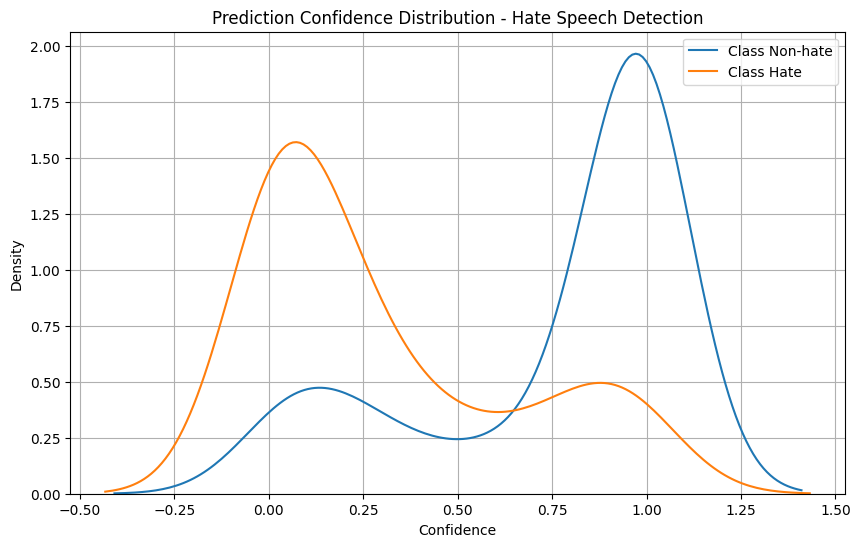


Getting predictions for Task 2: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]



==================== Sarcasm Detection Results ====================
Average Loss: 0.9689
F1 Score (weighted): 0.4549

Classification Report:
               precision    recall  f1-score   support

Non-sarcastic       0.54      0.43      0.48       103
    Sarcastic       0.38      0.49      0.43        74

     accuracy                           0.45       177
    macro avg       0.46      0.46      0.45       177
 weighted avg       0.47      0.45      0.45       177



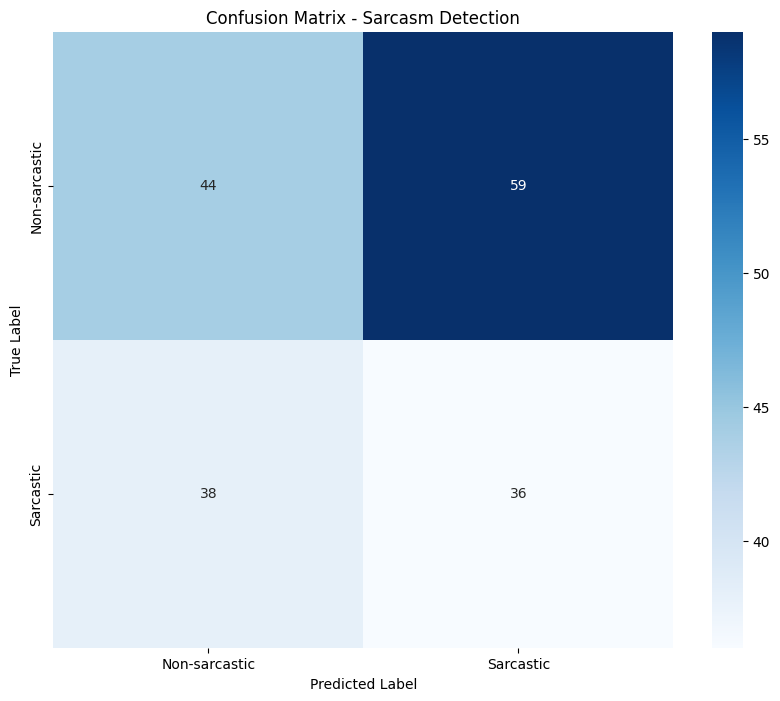

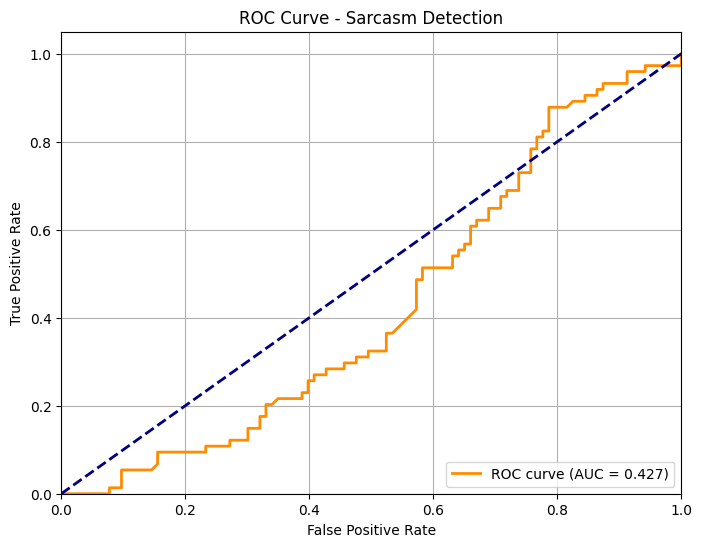

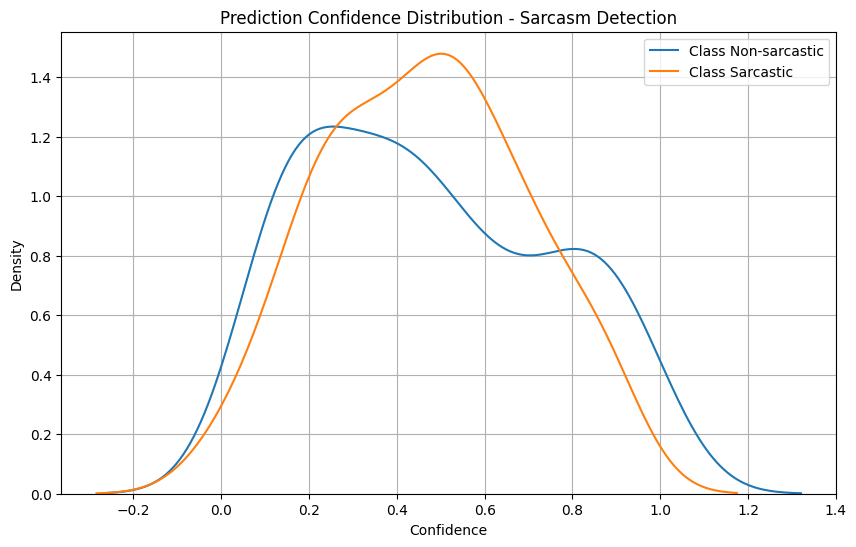

In [141]:
# Evaluate individual task
task1_results = evaluate_model(
    model=model,
    test_dataloader=slur_dataloader,
    device=device,
    task_id=1,
    task_name="Hate Speech Detection",
    class_names=['Non-hate', 'Hate']
)

# Or evaluate all tasks at once
all_results = evaluate_all_tasks(model, val_dataloader, device)


Getting predictions for Task 1: 100%|██████████| 26/26 [00:05<00:00,  5.03it/s]



==================== Hate Speech Detection Results ====================
Average Loss: 2.1174
F1 Score (weighted): 0.5314

Classification Report:
              precision    recall  f1-score   support

    Non-hate       0.28      0.81      0.42       177
        Hate       0.89      0.41      0.56       632

    accuracy                           0.50       809
   macro avg       0.58      0.61      0.49       809
weighted avg       0.75      0.50      0.53       809



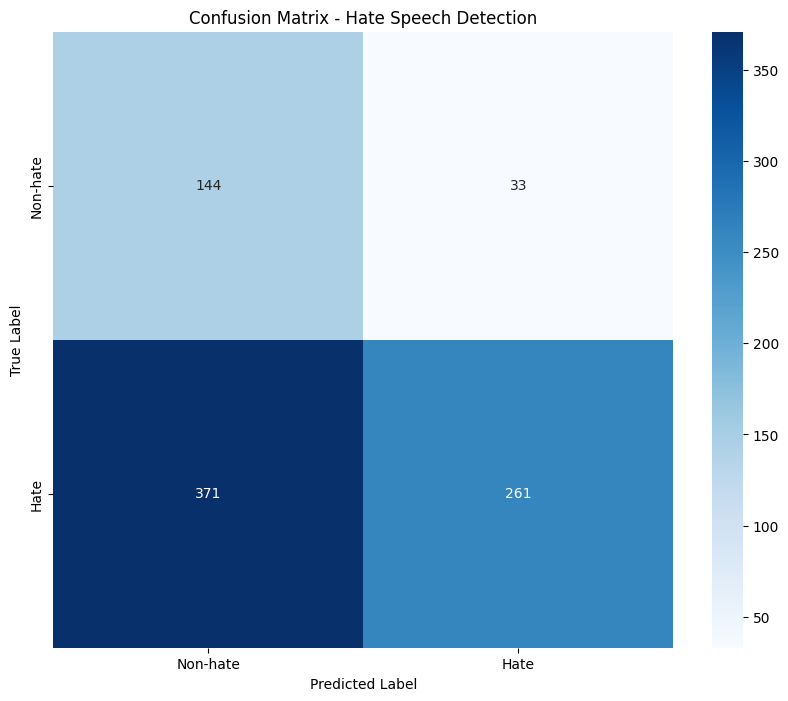

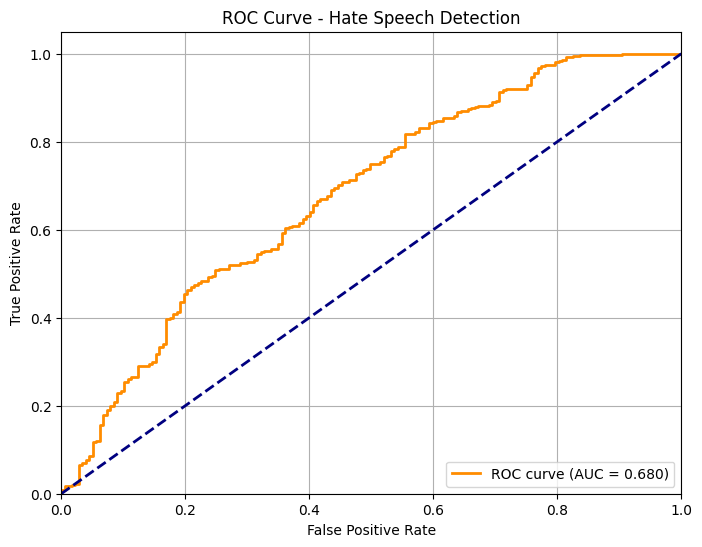

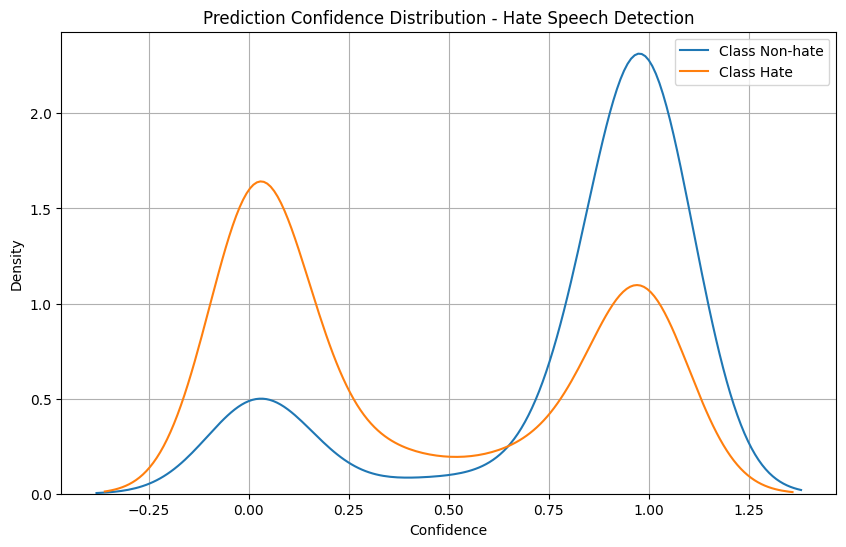


Getting predictions for Task 1: 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]



==================== Hate Speech Detection Results ====================
Average Loss: 1.4265
F1 Score (weighted): 0.5313

Classification Report:
              precision    recall  f1-score   support

    Non-hate       0.59      0.77      0.67       103
        Hate       0.45      0.27      0.34        74

    accuracy                           0.56       177
   macro avg       0.52      0.52      0.50       177
weighted avg       0.54      0.56      0.53       177



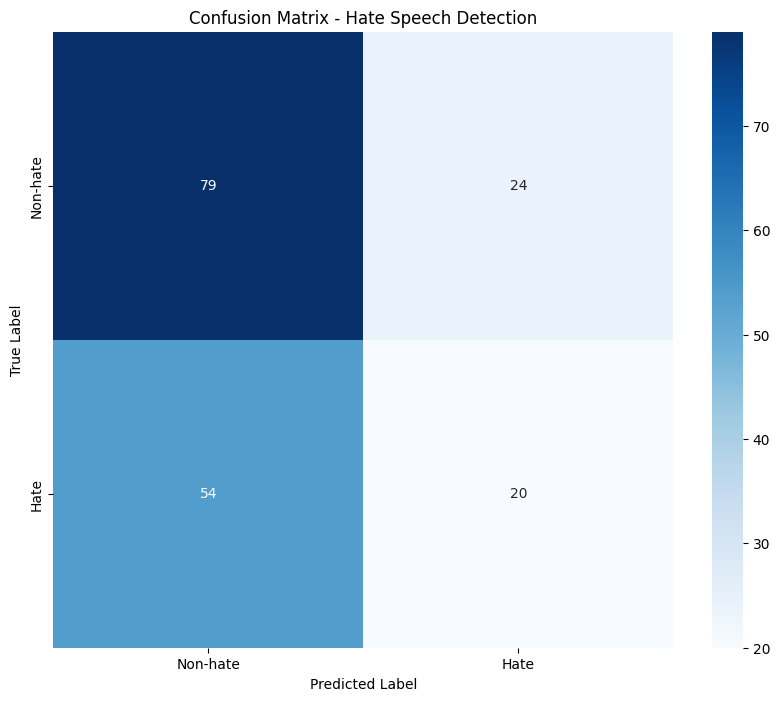

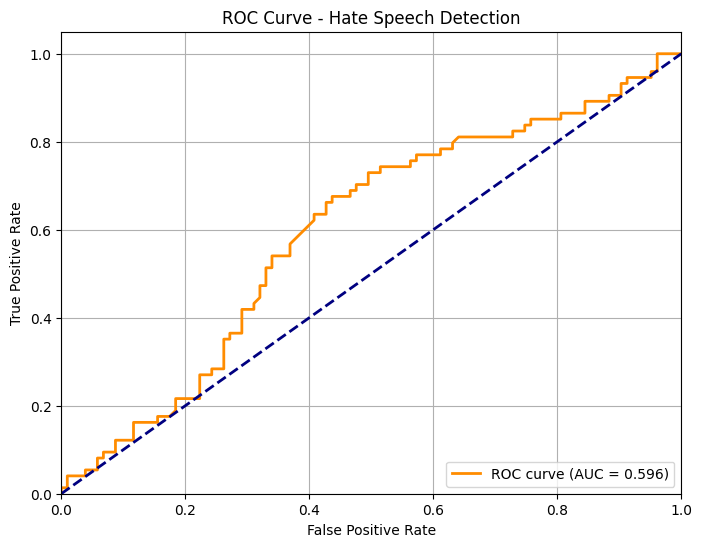

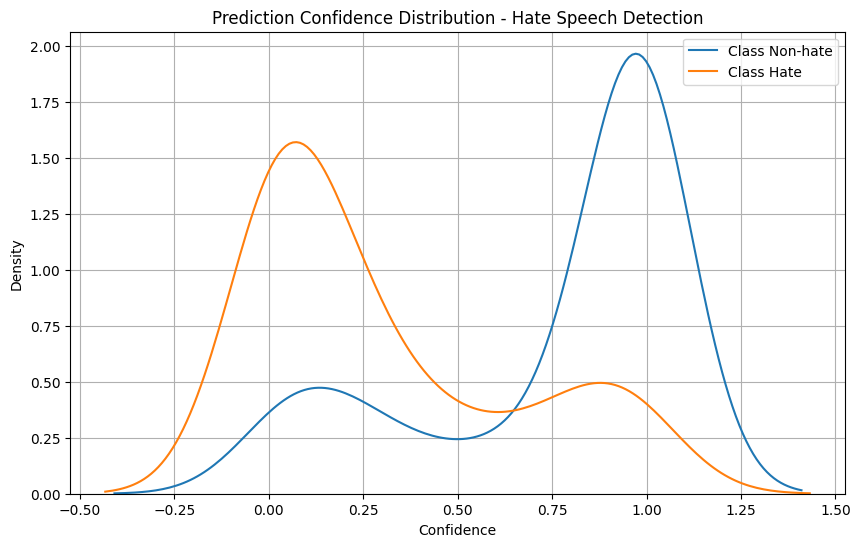


Getting predictions for Task 2: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]



==================== Sarcasm Detection Results ====================
Average Loss: 0.9689
F1 Score (weighted): 0.4549

Classification Report:
               precision    recall  f1-score   support

Non-sarcastic       0.54      0.43      0.48       103
    Sarcastic       0.38      0.49      0.43        74

     accuracy                           0.45       177
    macro avg       0.46      0.46      0.45       177
 weighted avg       0.47      0.45      0.45       177



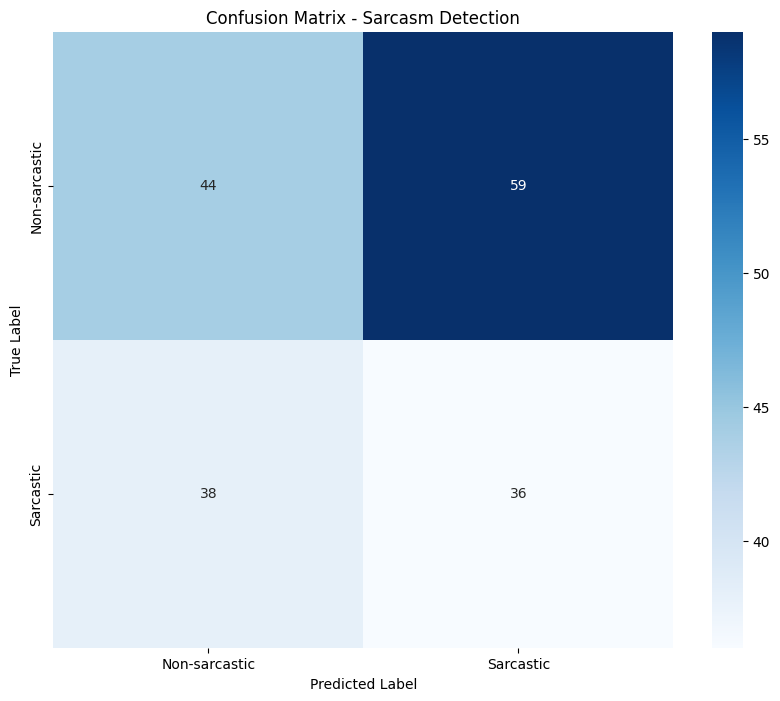

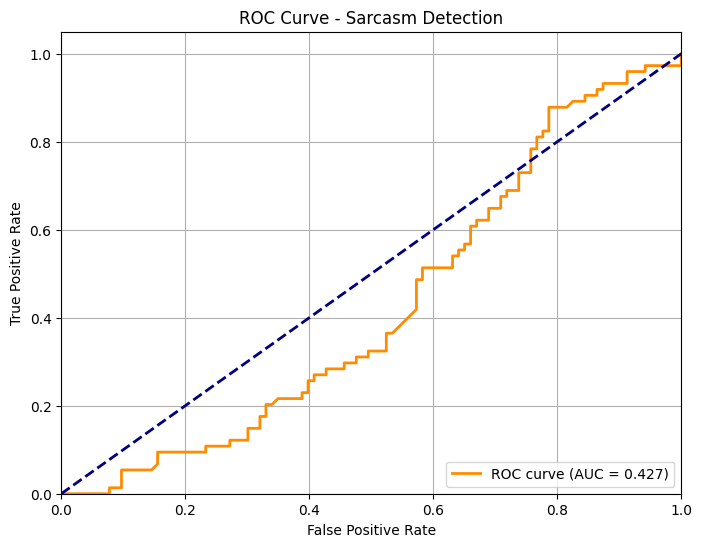

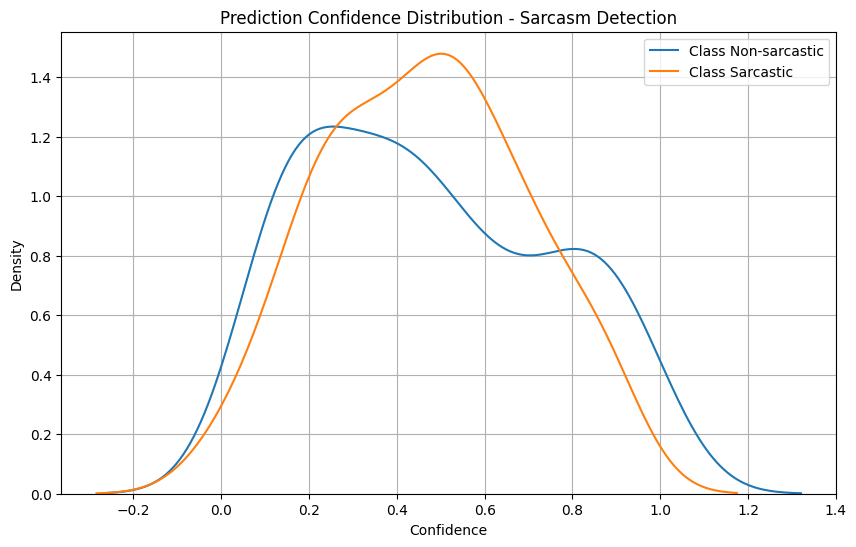

In [142]:
# Evaluate individual task
task1_results = evaluate_model(
    model=model,
    test_dataloader=chan_dataloader,
    device=device,
    task_id=1,
    task_name="Hate Speech Detection",
    class_names=['Non-hate', 'Hate']
)

# Or evaluate all tasks at once
all_results = evaluate_all_tasks(model, val_dataloader, device)

## HateXplain

In [157]:
torch.cuda.empty_cache()
gc.collect()

0

In [161]:
import torch
from torch.cuda.amp import autocast, GradScaler
from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import DataLoader, SequentialSampler, TensorDataset
from sklearn.metrics import classification_report
import gc
import logging

In [162]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("Hate-speech-CNERG/bert-base-uncased-hatexplain")
model = AutoModelForSequenceClassification.from_pretrained("Hate-speech-CNERG/bert-base-uncased-hatexplain")

# Move model to device
model.to(device)

tokenizer_config.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [163]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def predict(texts, batch_size=8):
    logging.info("Starting the prediction process.")

    # Tokenize and encode the text data with padding to max_length
    encoded_data = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=200,
        padding='max_length',  # Pad to max_length
        return_attention_mask=True,
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoded_data['input_ids']
    attention_masks = encoded_data['attention_mask']

    logging.info(f"Tokenized {len(texts)} texts.")

    # Create TensorDataset and DataLoader
    dataset = TensorDataset(input_ids, attention_masks)
    dataloader = DataLoader(dataset, sampler=SequentialSampler(dataset), batch_size=batch_size)

    predictions = []
    total_batches = len(dataloader)
    logging.info(f"Total batches: {total_batches}")

    for i, batch in enumerate(dataloader):
        batch = tuple(b.to(device) for b in batch)
        input_ids, attention_masks = batch

        with torch.no_grad():
            with torch.cuda.amp.autocast():  # Mixed precision inference
                outputs = model(input_ids, attention_mask=attention_masks)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())

        if (i + 1) % 10 == 0:
            logging.info(f"Processed batch {i + 1}/{total_batches}")

    logging.info("Prediction process completed.")
    return predictions

In [165]:
texts = list(slur_test['body'])
predictions = predict(texts, batch_size=16)
labels = slur_test['gold_label'].values

report = classification_report(labels, predictions)
print("\n Test Classification Report:\n", report)


 Test Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.22      0.28       509
           1       0.81      0.25      0.38       491
           2       0.00      0.00      0.00         0

    accuracy                           0.23      1000
   macro avg       0.39      0.16      0.22      1000
weighted avg       0.59      0.23      0.33      1000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [168]:
texts = list(chan['text'])
predictions = predict(texts, batch_size=16)
labels = chan['label'].values

report = classification_report(labels, predictions)
print("\n 4chan Classification Report:\n", report)


 4chan Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.36      0.52       177
           1       0.92      0.89      0.91       632
           2       0.00      0.00      0.00         0

    accuracy                           0.78       809
   macro avg       0.61      0.42      0.47       809
weighted avg       0.92      0.78      0.82       809



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [169]:
texts = list(val_com)
predictions = predict(texts, batch_size=4)
transformed_predictions = [1 if label != 0 else 0 for label in predictions]

results_df = pd.DataFrame({
    'Text': texts,
    'Original Label': val_df['label'],
    'Predicted Label': transformed_predictions
})

labels = val_df['label'].values
report = classification_report(labels, predictions)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.23      0.37       103
           1       0.46      0.77      0.58        74
           2       0.00      0.00      0.00         0

    accuracy                           0.46       177
   macro avg       0.46      0.33      0.32       177
weighted avg       0.73      0.46      0.46       177



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [170]:
results_df.to_csv('hatexplainresults.csv', index=False)
results_df

,Text,Original Label,Predicted Label
0,killing muslims is bad,1,1
1,imagine thinking that killing muslims is bad,0,1
2,imagine that,1,1
3,muslim,1,1
4,arab,1,1
...,...,...,...
172,the jewish conspiracy is tinfoil bs that has t...,0,0
173,the world is gonna get very niggly soon,0,0
174,hows thanksgiving looking tomorrow for you wil...,1,1
175,you think blacks and hispanics are subhuman je...,1,1
